In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
zip_path = '/content/drive/MyDrive/New_image.zip'

In [6]:
!unzip -q '/content/drive/MyDrive/New_images.zip' -d '/content/New_images'

In [7]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, '/content/drive/MyDrive/model.pth')

In [8]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/accuracy.png')

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/loss.png')

In [9]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
# ratio of data to use for validation
valid_split = 0.2
# batch size
batch_size = 64
# path to the data root directory
root_dir = '/content/New_images/New_images'

In [10]:
# define the training transforms and augmentations
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [11]:
# initial entire and test datasets
dataset = datasets.ImageFolder(root_dir, transform=train_transform)
dataset_test = datasets.ImageFolder(root_dir, transform=valid_transform)
print(f"Classes: {dataset.classes}")
dataset_size = len(dataset)
print(f"Total number of images: {dataset_size}")
valid_size = int(valid_split*dataset_size)
# training and validation sets
indices = torch.randperm(len(dataset)).tolist()
dataset_train = Subset(dataset, indices[:-valid_size])
dataset_valid = Subset(dataset_test, indices[-valid_size:])
print(f"Total training images: {len(dataset_train)}")
print(f"Total valid_images: {len(dataset_valid)}")
# training and validation data loaders
train_loader = DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=4
)
valid_loader = DataLoader(
    dataset_valid, batch_size=batch_size, shuffle=False, num_workers=4
)

Classes: ['Dense_Forest', 'Settlement', 'Vegetation', 'Water_body']
Total number of images: 26611
Total training images: 21289
Total valid_images: 5322


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [2]:
import torchvision.models as models
import torch.nn as nn
def build_model(pretrained=True, fine_tune=True, num_classes=1):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    elif not pretrained:
        print('[INFO]: Not loading pre-trained weights')
    model = models.resnet34(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # change the final classification head, it is trainable
    model.fc = nn.Linear(512, num_classes)
    return model

In [3]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm


In [28]:
import argparse

# Define the arguments manually
epochs = 40  # Set the default value

# Parse command-line arguments (manually set)
args = {'epochs': epochs}

# Access the argument values
num_epochs = args['epochs']

# Now you can use the 'num_epochs' variable in your code


In [29]:
# learning_parameters
lr = 0.001
epochs = args['epochs']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cuda



In [30]:
print(epochs)

40


In [54]:
# build the model
model = build_model(
    pretrained=True, fine_tune=False, num_classes=len(dataset.classes)
).to(device)
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function
criterion = nn.CrossEntropyLoss()

NameError: name 'dataset' is not defined

In [32]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [33]:
# validation
def validate(model, testloader, criterion, class_names):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(len(class_names)))
    class_total = list(0. for i in range(len(class_names)))

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

            # calculate the accuracy for each class
            correct  = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))

    # print the accuracy for each class after every epoch
    print('\n')
    for i in range(len(class_names)):
        print(f"Accuracy of class {class_names[i]}: {100*class_correct[i]/class_total[i]}")
    print('\n')

    return epoch_loss, epoch_acc

[INFO]: Epoch 1 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 95.5743879472693
Accuracy of class Settlement: 97.7645305514158
Accuracy of class Vegetation: 95.49436795994994
Accuracy of class Water_body: 85.48657718120805


Training loss: 0.221, training acc: 93.875
Validation loss: 0.257, validation acc: 93.555
--------------------------------------------------
[INFO]: Epoch 2 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 97.08097928436912
Accuracy of class Settlement: 99.2548435171386
Accuracy of class Vegetation: 93.99249061326658
Accuracy of class Water_body: 91.35906040268456


Training loss: 0.081, training acc: 97.755
Validation loss: 0.200, validation acc: 94.682
--------------------------------------------------
[INFO]: Epoch 3 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 95.66854990583803
Accuracy of class Settlement: 99.2548435171386
Accuracy of class Vegetation: 96.20358781810596
Accuracy of class Water_body: 91.86241610738254


Training loss: 0.066, training acc: 98.163
Validation loss: 0.173, validation acc: 95.509
--------------------------------------------------
[INFO]: Epoch 4 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 94.91525423728814
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 95.49436795994994
Accuracy of class Water_body: 94.37919463087249


Training loss: 0.058, training acc: 98.309
Validation loss: 0.154, validation acc: 95.641
--------------------------------------------------
[INFO]: Epoch 5 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 91.52542372881356
Accuracy of class Settlement: 99.40387481371089
Accuracy of class Vegetation: 96.5790571547768
Accuracy of class Water_body: 94.63087248322148


Training loss: 0.055, training acc: 98.271
Validation loss: 0.148, validation acc: 95.490
--------------------------------------------------
[INFO]: Epoch 6 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 97.92843691148776
Accuracy of class Settlement: 99.40387481371089
Accuracy of class Vegetation: 97.20483938256153
Accuracy of class Water_body: 93.95973154362416


Training loss: 0.051, training acc: 98.487
Validation loss: 0.122, validation acc: 96.900
--------------------------------------------------
[INFO]: Epoch 7 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 90.67796610169492
Accuracy of class Settlement: 99.40387481371089
Accuracy of class Vegetation: 97.03796412181894
Accuracy of class Water_body: 93.20469798657719


Training loss: 0.052, training acc: 98.398
Validation loss: 0.156, validation acc: 95.209
--------------------------------------------------
[INFO]: Epoch 8 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 93.97363465160075
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 97.07968293700459
Accuracy of class Water_body: 95.21812080536913


Training loss: 0.047, training acc: 98.441
Validation loss: 0.123, validation acc: 96.355
--------------------------------------------------
[INFO]: Epoch 9 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 94.25612052730696
Accuracy of class Settlement: 99.85096870342772
Accuracy of class Vegetation: 96.03671255736337
Accuracy of class Water_body: 90.26845637583892


Training loss: 0.049, training acc: 98.408
Validation loss: 0.178, validation acc: 94.870
--------------------------------------------------
[INFO]: Epoch 10 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 94.53860640301318
Accuracy of class Settlement: 99.70193740685544
Accuracy of class Vegetation: 96.28702544847727
Accuracy of class Water_body: 95.88926174496645


Training loss: 0.050, training acc: 98.332
Validation loss: 0.120, validation acc: 96.280
--------------------------------------------------
[INFO]: Epoch 11 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 97.08097928436912
Accuracy of class Settlement: 99.2548435171386
Accuracy of class Vegetation: 97.78890279516062
Accuracy of class Water_body: 94.12751677852349


Training loss: 0.046, training acc: 98.563
Validation loss: 0.111, validation acc: 97.012
--------------------------------------------------
[INFO]: Epoch 12 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 93.97363465160075
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 97.83062161034627
Accuracy of class Water_body: 94.46308724832215


Training loss: 0.046, training acc: 98.619
Validation loss: 0.121, validation acc: 96.524
--------------------------------------------------
[INFO]: Epoch 13 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 77.49529190207156
Accuracy of class Settlement: 99.40387481371089
Accuracy of class Vegetation: 98.66499791405924
Accuracy of class Water_body: 91.69463087248322


Training loss: 0.044, training acc: 98.534
Validation loss: 0.208, validation acc: 92.973
--------------------------------------------------
[INFO]: Epoch 14 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 93.22033898305085
Accuracy of class Settlement: 99.40387481371089
Accuracy of class Vegetation: 97.91405924071756
Accuracy of class Water_body: 91.35906040268456


Training loss: 0.043, training acc: 98.619
Validation loss: 0.141, validation acc: 95.697
--------------------------------------------------
[INFO]: Epoch 15 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 95.48022598870057
Accuracy of class Settlement: 99.70193740685544
Accuracy of class Vegetation: 98.03921568627452
Accuracy of class Water_body: 94.54697986577182


Training loss: 0.044, training acc: 98.652
Validation loss: 0.109, validation acc: 96.956
--------------------------------------------------
[INFO]: Epoch 16 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 90.20715630885122
Accuracy of class Settlement: 99.70193740685544
Accuracy of class Vegetation: 97.99749687108886
Accuracy of class Water_body: 92.28187919463087


Training loss: 0.042, training acc: 98.619
Validation loss: 0.151, validation acc: 95.378
--------------------------------------------------
[INFO]: Epoch 17 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 90.3954802259887
Accuracy of class Settlement: 99.2548435171386
Accuracy of class Vegetation: 98.49812265331664
Accuracy of class Water_body: 93.12080536912751


Training loss: 0.042, training acc: 98.727
Validation loss: 0.140, validation acc: 95.772
--------------------------------------------------
[INFO]: Epoch 18 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 91.33709981167608
Accuracy of class Settlement: 99.70193740685544
Accuracy of class Vegetation: 97.62202753441802
Accuracy of class Water_body: 95.13422818791946


Training loss: 0.043, training acc: 98.685
Validation loss: 0.127, validation acc: 96.073
--------------------------------------------------
[INFO]: Epoch 19 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 93.22033898305085
Accuracy of class Settlement: 99.70193740685544
Accuracy of class Vegetation: 97.78890279516062
Accuracy of class Water_body: 95.72147651006712


Training loss: 0.041, training acc: 98.732
Validation loss: 0.105, validation acc: 96.655
--------------------------------------------------
[INFO]: Epoch 20 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 79.09604519774011
Accuracy of class Settlement: 99.70193740685544
Accuracy of class Vegetation: 98.2060909470171
Accuracy of class Water_body: 95.88926174496645


Training loss: 0.045, training acc: 98.610
Validation loss: 0.172, validation acc: 94.062
--------------------------------------------------
[INFO]: Epoch 21 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 83.89830508474576
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 98.2895285773884
Accuracy of class Water_body: 95.88926174496645


Training loss: 0.039, training acc: 98.807
Validation loss: 0.140, validation acc: 95.039
--------------------------------------------------
[INFO]: Epoch 22 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 82.29755178907722
Accuracy of class Settlement: 99.40387481371089
Accuracy of class Vegetation: 98.66499791405924
Accuracy of class Water_body: 95.21812080536913


Training loss: 0.042, training acc: 98.685
Validation loss: 0.152, validation acc: 94.720
--------------------------------------------------
[INFO]: Epoch 23 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 88.22975517890772
Accuracy of class Settlement: 99.40387481371089
Accuracy of class Vegetation: 98.6232790988736
Accuracy of class Water_body: 95.38590604026845


Training loss: 0.042, training acc: 98.586
Validation loss: 0.120, validation acc: 95.923
--------------------------------------------------
[INFO]: Epoch 24 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 92.93785310734464
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 98.08093450146016
Accuracy of class Water_body: 95.38590604026845


Training loss: 0.043, training acc: 98.741
Validation loss: 0.108, validation acc: 96.637
--------------------------------------------------
[INFO]: Epoch 25 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 82.39171374764595
Accuracy of class Settlement: 99.2548435171386
Accuracy of class Vegetation: 98.74843554443054
Accuracy of class Water_body: 94.46308724832215


Training loss: 0.038, training acc: 98.816
Validation loss: 0.159, validation acc: 94.589
--------------------------------------------------
[INFO]: Epoch 26 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 87.1939736346516
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 98.456403838131
Accuracy of class Water_body: 93.79194630872483


Training loss: 0.043, training acc: 98.647
Validation loss: 0.154, validation acc: 95.303
--------------------------------------------------
[INFO]: Epoch 27 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 89.92467043314501
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 98.3729662077597
Accuracy of class Water_body: 93.8758389261745


Training loss: 0.040, training acc: 98.675
Validation loss: 0.142, validation acc: 95.829
--------------------------------------------------
[INFO]: Epoch 28 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 93.03201506591337
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 97.95577805590321
Accuracy of class Water_body: 94.04362416107382


Training loss: 0.040, training acc: 98.694
Validation loss: 0.124, validation acc: 96.298
--------------------------------------------------
[INFO]: Epoch 29 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 93.40866290018832
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 98.03921568627452
Accuracy of class Water_body: 95.46979865771812


Training loss: 0.040, training acc: 98.708
Validation loss: 0.102, validation acc: 96.731
--------------------------------------------------
[INFO]: Epoch 30 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 87.57062146892656
Accuracy of class Settlement: 99.85096870342772
Accuracy of class Vegetation: 97.24655819774718
Accuracy of class Water_body: 91.69463087248322


Training loss: 0.040, training acc: 98.736
Validation loss: 0.194, validation acc: 94.401
--------------------------------------------------
[INFO]: Epoch 31 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 92.56120527306967
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 97.49687108886107
Accuracy of class Water_body: 95.30201342281879


Training loss: 0.040, training acc: 98.755
Validation loss: 0.118, validation acc: 96.280
--------------------------------------------------
[INFO]: Epoch 32 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 93.69114877589453
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 98.456403838131
Accuracy of class Water_body: 91.69463087248322


Training loss: 0.042, training acc: 98.727
Validation loss: 0.134, validation acc: 96.129
--------------------------------------------------
[INFO]: Epoch 33 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 95.76271186440678
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 98.2895285773884
Accuracy of class Water_body: 94.71476510067114


Training loss: 0.040, training acc: 98.830
Validation loss: 0.102, validation acc: 97.144
--------------------------------------------------
[INFO]: Epoch 34 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 92.46704331450094
Accuracy of class Settlement: 99.70193740685544
Accuracy of class Vegetation: 97.24655819774718
Accuracy of class Water_body: 94.21140939597315


Training loss: 0.040, training acc: 98.736
Validation loss: 0.134, validation acc: 95.923
--------------------------------------------------
[INFO]: Epoch 35 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 92.37288135593221
Accuracy of class Settlement: 99.70193740685544
Accuracy of class Vegetation: 98.03921568627452
Accuracy of class Water_body: 92.95302013422818


Training loss: 0.038, training acc: 98.783
Validation loss: 0.137, validation acc: 95.979
--------------------------------------------------
[INFO]: Epoch 36 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 90.96045197740114
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 97.91405924071756
Accuracy of class Water_body: 90.60402684563758


Training loss: 0.039, training acc: 98.816
Validation loss: 0.157, validation acc: 95.096
--------------------------------------------------
[INFO]: Epoch 37 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 92.74952919020716
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 98.74843554443054
Accuracy of class Water_body: 90.43624161073825


Training loss: 0.037, training acc: 98.798
Validation loss: 0.138, validation acc: 95.791
--------------------------------------------------
[INFO]: Epoch 38 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 96.61016949152543
Accuracy of class Settlement: 99.70193740685544
Accuracy of class Vegetation: 97.41343345848978
Accuracy of class Water_body: 93.8758389261745


Training loss: 0.041, training acc: 98.793
Validation loss: 0.117, validation acc: 96.749
--------------------------------------------------
[INFO]: Epoch 39 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 95.66854990583803
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 98.456403838131
Accuracy of class Water_body: 93.95973154362416


Training loss: 0.040, training acc: 98.680
Validation loss: 0.105, validation acc: 97.031
--------------------------------------------------
[INFO]: Epoch 40 of 40
Training


  0%|          | 0/333 [00:00<?, ?it/s]

Validation


  0%|          | 0/84 [00:00<?, ?it/s]



Accuracy of class Dense_Forest: 93.50282485875707
Accuracy of class Settlement: 99.55290611028316
Accuracy of class Vegetation: 98.24780976220275
Accuracy of class Water_body: 95.46979865771812


Training loss: 0.037, training acc: 98.774
Validation loss: 0.102, validation acc: 96.843
--------------------------------------------------
TRAINING COMPLETE


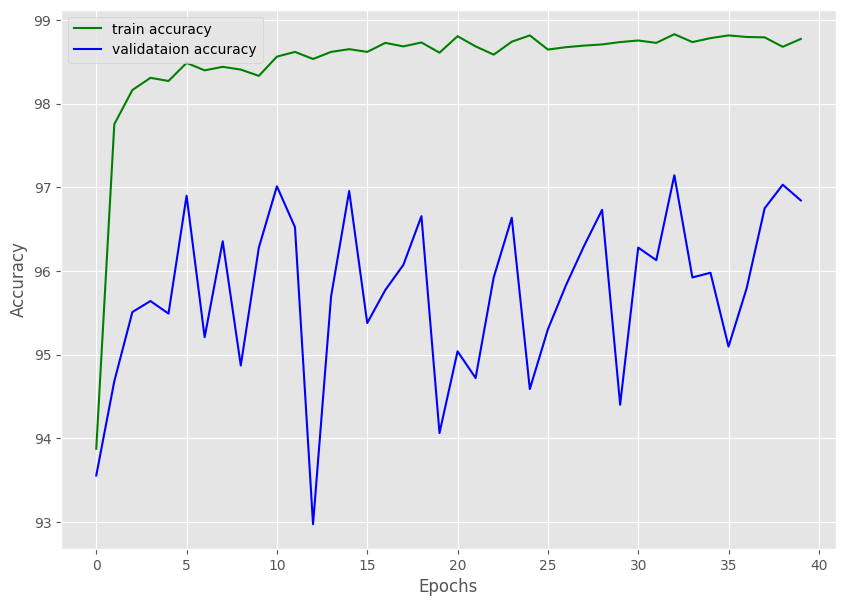

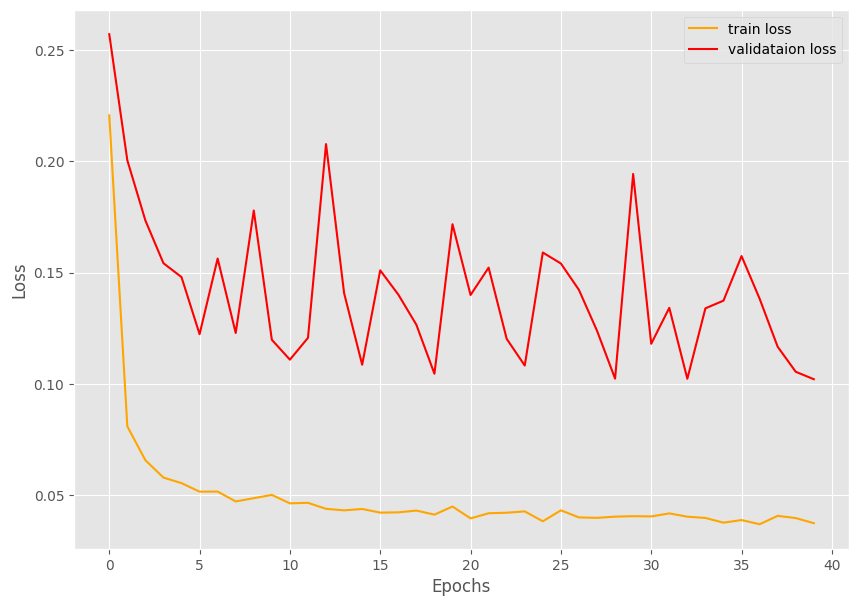

In [34]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader,
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,
                                                 criterion, dataset.classes)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

In [4]:
import cv2
import torchvision.transforms as transforms

In [5]:
# the computation device
device = 'cpu'

In [6]:
# list containing all the labels
labels = ['Dense_Forest', 'Settlement', 'Vegetation', 'Water_body']

In [7]:
savepath = 'model.pth'

In [8]:
# initialize the model and load the trained weights
model = build_model(
    pretrained=False, fine_tune=False, num_classes=4
).to(device)
print('[INFO]: Loading custom-trained weights...')
checkpoint = torch.load(savepath, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

[INFO]: Not loading pre-trained weights


C:\Users\Amani\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Amani\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[INFO]: Freezing hidden layers...
[INFO]: Loading custom-trained weights...


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# define preprocess transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]) 

In [92]:
# path200 = './NewImages/imagezz/._data_00009.tif'

In [102]:
# path200 = './New_images/Water_body/water_body (120).tif'

In [105]:
path200 = './New_images/Dense_Forest/dense_forest (77).tif'

In [106]:
# read and preprocess the image
image = cv2.imread(path200)
# # convert to RGB format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = transform(image)
# # add batch dimension
image = torch.unsqueeze(image, 0)
with torch.no_grad():
    outputs = model(image.to(device))
output_label = torch.topk(outputs, 1)
pred_class_index = int(output_label.indices)
pred_class = labels[int(output_label.indices)]



In [107]:
print(pred_class_index)

0


In [108]:
print(pred_class)

Dense_Forest


In [10]:
import os

In [11]:
 image_folder = './NewImages/imagesss'

In [12]:
# Get the list of image files in the image folder
# image_folder = './mydata/imagess'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')]

In [13]:
print(image_files)

['./NewImages/imagesss\\._data_00001.tif', './NewImages/imagesss\\._data_00002.tif', './NewImages/imagesss\\._data_00003.tif', './NewImages/imagesss\\._data_00004.tif', './NewImages/imagesss\\._data_00005.tif', './NewImages/imagesss\\._data_00006.tif', './NewImages/imagesss\\._data_00007.tif', './NewImages/imagesss\\._data_00008.tif', './NewImages/imagesss\\._data_00009.tif', './NewImages/imagesss\\._data_00010.tif', './NewImages/imagesss\\._data_00011.tif', './NewImages/imagesss\\._data_00012.tif', './NewImages/imagesss\\._data_00013.tif', './NewImages/imagesss\\._data_00014.tif', './NewImages/imagesss\\._data_00015.tif', './NewImages/imagesss\\._data_00016.tif', './NewImages/imagesss\\._data_00017.tif', './NewImages/imagesss\\._data_00018.tif', './NewImages/imagesss\\._data_00019.tif', './NewImages/imagesss\\._data_00020.tif', './NewImages/imagesss\\._data_00021.tif', './NewImages/imagesss\\._data_00022.tif', './NewImages/imagesss\\._data_00023.tif', './NewImages/imagesss\\._data_000

In [14]:
model = build_model(
    pretrained=False, fine_tune=False, num_classes=4
).to(device)
print('[INFO]: Loading custom-trained weights...')
checkpoint = torch.load(savepath, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

[INFO]: Not loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading custom-trained weights...


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [81]:
for file in image_files:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image)
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image.to(device))
    output_label = torch.topk(outputs, 1)
    pred_class = labels[int(output_label.indices)]
    print(f"{file}: {pred_class}")
    
    

./NewImages/imagezz\._data_00001.tif: Settlement
./NewImages/imagezz\._data_00002.tif: Settlement
./NewImages/imagezz\._data_00003.tif: Settlement
./NewImages/imagezz\._data_00004.tif: Settlement
./NewImages/imagezz\._data_00005.tif: Settlement
./NewImages/imagezz\._data_00006.tif: Settlement
./NewImages/imagezz\._data_00007.tif: Vegetation
./NewImages/imagezz\._data_00008.tif: Settlement
./NewImages/imagezz\._data_00009.tif: Vegetation
./NewImages/imagezz\._data_00010.tif: Vegetation
./NewImages/imagezz\._data_00011.tif: Vegetation
./NewImages/imagezz\._data_00012.tif: Vegetation
./NewImages/imagezz\._data_00013.tif: Settlement
./NewImages/imagezz\._data_00014.tif: Vegetation
./NewImages/imagezz\._data_00015.tif: Vegetation
./NewImages/imagezz\._data_00016.tif: Vegetation
./NewImages/imagezz\._data_00017.tif: Vegetation
./NewImages/imagezz\._data_00018.tif: Vegetation
./NewImages/imagezz\._data_00019.tif: Vegetation
./NewImages/imagezz\._data_00020.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_00169.tif: Settlement
./NewImages/imagezz\._data_00170.tif: Settlement
./NewImages/imagezz\._data_00171.tif: Settlement
./NewImages/imagezz\._data_00172.tif: Vegetation
./NewImages/imagezz\._data_00173.tif: Settlement
./NewImages/imagezz\._data_00174.tif: Settlement
./NewImages/imagezz\._data_00175.tif: Settlement
./NewImages/imagezz\._data_00176.tif: Vegetation
./NewImages/imagezz\._data_00177.tif: Vegetation
./NewImages/imagezz\._data_00178.tif: Vegetation
./NewImages/imagezz\._data_00179.tif: Settlement
./NewImages/imagezz\._data_00180.tif: Settlement
./NewImages/imagezz\._data_00181.tif: Settlement
./NewImages/imagezz\._data_00182.tif: Settlement
./NewImages/imagezz\._data_00183.tif: Settlement
./NewImages/imagezz\._data_00184.tif: Settlement
./NewImages/imagezz\._data_00185.tif: Settlement
./NewImages/imagezz\._data_00186.tif: Settlement
./NewImages/imagezz\._data_00187.tif: Settlement
./NewImages/imagezz\._data_00188.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_00337.tif: Settlement
./NewImages/imagezz\._data_00338.tif: Settlement
./NewImages/imagezz\._data_00339.tif: Settlement
./NewImages/imagezz\._data_00340.tif: Settlement
./NewImages/imagezz\._data_00341.tif: Settlement
./NewImages/imagezz\._data_00342.tif: Settlement
./NewImages/imagezz\._data_00343.tif: Vegetation
./NewImages/imagezz\._data_00344.tif: Settlement
./NewImages/imagezz\._data_00345.tif: Settlement
./NewImages/imagezz\._data_00346.tif: Settlement
./NewImages/imagezz\._data_00347.tif: Settlement
./NewImages/imagezz\._data_00348.tif: Settlement
./NewImages/imagezz\._data_00349.tif: Settlement
./NewImages/imagezz\._data_00350.tif: Settlement
./NewImages/imagezz\._data_00351.tif: Vegetation
./NewImages/imagezz\._data_00352.tif: Settlement
./NewImages/imagezz\._data_00353.tif: Settlement
./NewImages/imagezz\._data_00354.tif: Settlement
./NewImages/imagezz\._data_00355.tif: Vegetation
./NewImages/imagezz\._data_00356.tif: Vegetation
./NewImages/imagezz\

./NewImages/imagezz\._data_00505.tif: Settlement
./NewImages/imagezz\._data_00506.tif: Settlement
./NewImages/imagezz\._data_00507.tif: Settlement
./NewImages/imagezz\._data_00508.tif: Vegetation
./NewImages/imagezz\._data_00509.tif: Vegetation
./NewImages/imagezz\._data_00510.tif: Vegetation
./NewImages/imagezz\._data_00511.tif: Settlement
./NewImages/imagezz\._data_00512.tif: Settlement
./NewImages/imagezz\._data_00513.tif: Settlement
./NewImages/imagezz\._data_00514.tif: Settlement
./NewImages/imagezz\._data_00515.tif: Settlement
./NewImages/imagezz\._data_00516.tif: Settlement
./NewImages/imagezz\._data_00517.tif: Settlement
./NewImages/imagezz\._data_00518.tif: Settlement
./NewImages/imagezz\._data_00519.tif: Vegetation
./NewImages/imagezz\._data_00520.tif: Vegetation
./NewImages/imagezz\._data_00521.tif: Vegetation
./NewImages/imagezz\._data_00522.tif: Vegetation
./NewImages/imagezz\._data_00523.tif: Vegetation
./NewImages/imagezz\._data_00524.tif: Vegetation
./NewImages/imagezz\

./NewImages/imagezz\._data_00673.tif: Settlement
./NewImages/imagezz\._data_00674.tif: Settlement
./NewImages/imagezz\._data_00675.tif: Settlement
./NewImages/imagezz\._data_00676.tif: Settlement
./NewImages/imagezz\._data_00677.tif: Vegetation
./NewImages/imagezz\._data_00678.tif: Settlement
./NewImages/imagezz\._data_00679.tif: Settlement
./NewImages/imagezz\._data_00680.tif: Settlement
./NewImages/imagezz\._data_00681.tif: Settlement
./NewImages/imagezz\._data_00682.tif: Settlement
./NewImages/imagezz\._data_00683.tif: Vegetation
./NewImages/imagezz\._data_00684.tif: Settlement
./NewImages/imagezz\._data_00685.tif: Settlement
./NewImages/imagezz\._data_00686.tif: Settlement
./NewImages/imagezz\._data_00687.tif: Settlement
./NewImages/imagezz\._data_00688.tif: Settlement
./NewImages/imagezz\._data_00689.tif: Vegetation
./NewImages/imagezz\._data_00690.tif: Vegetation
./NewImages/imagezz\._data_00691.tif: Vegetation
./NewImages/imagezz\._data_00692.tif: Vegetation
./NewImages/imagezz\

./NewImages/imagezz\._data_00841.tif: Settlement
./NewImages/imagezz\._data_00842.tif: Settlement
./NewImages/imagezz\._data_00843.tif: Settlement
./NewImages/imagezz\._data_00844.tif: Settlement
./NewImages/imagezz\._data_00845.tif: Settlement
./NewImages/imagezz\._data_00846.tif: Settlement
./NewImages/imagezz\._data_00847.tif: Settlement
./NewImages/imagezz\._data_00848.tif: Settlement
./NewImages/imagezz\._data_00849.tif: Settlement
./NewImages/imagezz\._data_00850.tif: Settlement
./NewImages/imagezz\._data_00851.tif: Settlement
./NewImages/imagezz\._data_00852.tif: Vegetation
./NewImages/imagezz\._data_00853.tif: Vegetation
./NewImages/imagezz\._data_00854.tif: Vegetation
./NewImages/imagezz\._data_00855.tif: Vegetation
./NewImages/imagezz\._data_00856.tif: Settlement
./NewImages/imagezz\._data_00857.tif: Settlement
./NewImages/imagezz\._data_00858.tif: Settlement
./NewImages/imagezz\._data_00859.tif: Settlement
./NewImages/imagezz\._data_00860.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_01176.tif: Settlement
./NewImages/imagezz\._data_01177.tif: Settlement
./NewImages/imagezz\._data_01178.tif: Vegetation
./NewImages/imagezz\._data_01179.tif: Vegetation
./NewImages/imagezz\._data_01180.tif: Vegetation
./NewImages/imagezz\._data_01181.tif: Vegetation
./NewImages/imagezz\._data_01182.tif: Vegetation
./NewImages/imagezz\._data_01183.tif: Vegetation
./NewImages/imagezz\._data_01184.tif: Vegetation
./NewImages/imagezz\._data_01185.tif: Vegetation
./NewImages/imagezz\._data_01186.tif: Vegetation
./NewImages/imagezz\._data_01187.tif: Vegetation
./NewImages/imagezz\._data_01188.tif: Settlement
./NewImages/imagezz\._data_01189.tif: Settlement
./NewImages/imagezz\._data_01190.tif: Settlement
./NewImages/imagezz\._data_01191.tif: Vegetation
./NewImages/imagezz\._data_01192.tif: Vegetation
./NewImages/imagezz\._data_01193.tif: Vegetation
./NewImages/imagezz\._data_01194.tif: Settlement
./NewImages/imagezz\._data_01195.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_01344.tif: Settlement
./NewImages/imagezz\._data_01345.tif: Settlement
./NewImages/imagezz\._data_01346.tif: Settlement
./NewImages/imagezz\._data_01347.tif: Vegetation
./NewImages/imagezz\._data_01348.tif: Vegetation
./NewImages/imagezz\._data_01349.tif: Vegetation
./NewImages/imagezz\._data_01350.tif: Vegetation
./NewImages/imagezz\._data_01351.tif: Vegetation
./NewImages/imagezz\._data_01352.tif: Vegetation
./NewImages/imagezz\._data_01353.tif: Vegetation
./NewImages/imagezz\._data_01354.tif: Vegetation
./NewImages/imagezz\._data_01355.tif: Vegetation
./NewImages/imagezz\._data_01356.tif: Vegetation
./NewImages/imagezz\._data_01357.tif: Settlement
./NewImages/imagezz\._data_01358.tif: Vegetation
./NewImages/imagezz\._data_01359.tif: Vegetation
./NewImages/imagezz\._data_01360.tif: Vegetation
./NewImages/imagezz\._data_01361.tif: Vegetation
./NewImages/imagezz\._data_01362.tif: Vegetation
./NewImages/imagezz\._data_01363.tif: Vegetation
./NewImages/imagezz\

./NewImages/imagezz\._data_01512.tif: Settlement
./NewImages/imagezz\._data_01513.tif: Vegetation
./NewImages/imagezz\._data_01514.tif: Vegetation
./NewImages/imagezz\._data_01515.tif: Vegetation
./NewImages/imagezz\._data_01516.tif: Vegetation
./NewImages/imagezz\._data_01517.tif: Vegetation
./NewImages/imagezz\._data_01518.tif: Vegetation
./NewImages/imagezz\._data_01519.tif: Vegetation
./NewImages/imagezz\._data_01520.tif: Vegetation
./NewImages/imagezz\._data_01521.tif: Vegetation
./NewImages/imagezz\._data_01522.tif: Vegetation
./NewImages/imagezz\._data_01523.tif: Vegetation
./NewImages/imagezz\._data_01524.tif: Vegetation
./NewImages/imagezz\._data_01525.tif: Vegetation
./NewImages/imagezz\._data_01526.tif: Vegetation
./NewImages/imagezz\._data_01527.tif: Vegetation
./NewImages/imagezz\._data_01528.tif: Vegetation
./NewImages/imagezz\._data_01529.tif: Settlement
./NewImages/imagezz\._data_01530.tif: Settlement
./NewImages/imagezz\._data_01531.tif: Vegetation
./NewImages/imagezz\

./NewImages/imagezz\._data_01681.tif: Vegetation
./NewImages/imagezz\._data_01682.tif: Vegetation
./NewImages/imagezz\._data_01683.tif: Vegetation
./NewImages/imagezz\._data_01684.tif: Vegetation
./NewImages/imagezz\._data_01685.tif: Vegetation
./NewImages/imagezz\._data_01686.tif: Vegetation
./NewImages/imagezz\._data_01687.tif: Vegetation
./NewImages/imagezz\._data_01688.tif: Vegetation
./NewImages/imagezz\._data_01689.tif: Vegetation
./NewImages/imagezz\._data_01690.tif: Vegetation
./NewImages/imagezz\._data_01691.tif: Vegetation
./NewImages/imagezz\._data_01692.tif: Settlement
./NewImages/imagezz\._data_01693.tif: Settlement
./NewImages/imagezz\._data_01694.tif: Settlement
./NewImages/imagezz\._data_01695.tif: Settlement
./NewImages/imagezz\._data_01696.tif: Settlement
./NewImages/imagezz\._data_01697.tif: Settlement
./NewImages/imagezz\._data_01698.tif: Settlement
./NewImages/imagezz\._data_01699.tif: Settlement
./NewImages/imagezz\._data_01700.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_01849.tif: Vegetation
./NewImages/imagezz\._data_01850.tif: Settlement
./NewImages/imagezz\._data_01851.tif: Settlement
./NewImages/imagezz\._data_01852.tif: Settlement
./NewImages/imagezz\._data_01853.tif: Settlement
./NewImages/imagezz\._data_01854.tif: Settlement
./NewImages/imagezz\._data_01855.tif: Settlement
./NewImages/imagezz\._data_01856.tif: Settlement
./NewImages/imagezz\._data_01857.tif: Settlement
./NewImages/imagezz\._data_01858.tif: Settlement
./NewImages/imagezz\._data_01859.tif: Settlement
./NewImages/imagezz\._data_01860.tif: Settlement
./NewImages/imagezz\._data_01861.tif: Settlement
./NewImages/imagezz\._data_01862.tif: Settlement
./NewImages/imagezz\._data_01863.tif: Settlement
./NewImages/imagezz\._data_01864.tif: Settlement
./NewImages/imagezz\._data_01865.tif: Settlement
./NewImages/imagezz\._data_01866.tif: Vegetation
./NewImages/imagezz\._data_01867.tif: Vegetation
./NewImages/imagezz\._data_01868.tif: Vegetation
./NewImages/imagezz\

./NewImages/imagezz\._data_02017.tif: Settlement
./NewImages/imagezz\._data_02018.tif: Settlement
./NewImages/imagezz\._data_02019.tif: Settlement
./NewImages/imagezz\._data_02020.tif: Settlement
./NewImages/imagezz\._data_02021.tif: Settlement
./NewImages/imagezz\._data_02022.tif: Settlement
./NewImages/imagezz\._data_02023.tif: Settlement
./NewImages/imagezz\._data_02024.tif: Settlement
./NewImages/imagezz\._data_02025.tif: Settlement
./NewImages/imagezz\._data_02026.tif: Vegetation
./NewImages/imagezz\._data_02027.tif: Vegetation
./NewImages/imagezz\._data_02028.tif: Vegetation
./NewImages/imagezz\._data_02029.tif: Vegetation
./NewImages/imagezz\._data_02030.tif: Vegetation
./NewImages/imagezz\._data_02031.tif: Vegetation
./NewImages/imagezz\._data_02032.tif: Vegetation
./NewImages/imagezz\._data_02033.tif: Vegetation
./NewImages/imagezz\._data_02034.tif: Vegetation
./NewImages/imagezz\._data_02035.tif: Settlement
./NewImages/imagezz\._data_02036.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_02185.tif: Settlement
./NewImages/imagezz\._data_02186.tif: Settlement
./NewImages/imagezz\._data_02187.tif: Settlement
./NewImages/imagezz\._data_02188.tif: Vegetation
./NewImages/imagezz\._data_02189.tif: Vegetation
./NewImages/imagezz\._data_02190.tif: Settlement
./NewImages/imagezz\._data_02191.tif: Settlement
./NewImages/imagezz\._data_02192.tif: Settlement
./NewImages/imagezz\._data_02193.tif: Settlement
./NewImages/imagezz\._data_02194.tif: Settlement
./NewImages/imagezz\._data_02195.tif: Settlement
./NewImages/imagezz\._data_02196.tif: Settlement
./NewImages/imagezz\._data_02197.tif: Settlement
./NewImages/imagezz\._data_02198.tif: Settlement
./NewImages/imagezz\._data_02199.tif: Settlement
./NewImages/imagezz\._data_02200.tif: Settlement
./NewImages/imagezz\._data_02201.tif: Settlement
./NewImages/imagezz\._data_02202.tif: Vegetation
./NewImages/imagezz\._data_02203.tif: Settlement
./NewImages/imagezz\._data_02204.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_02353.tif: Settlement
./NewImages/imagezz\._data_02354.tif: Vegetation
./NewImages/imagezz\._data_02355.tif: Settlement
./NewImages/imagezz\._data_02356.tif: Settlement
./NewImages/imagezz\._data_02357.tif: Settlement
./NewImages/imagezz\._data_02358.tif: Settlement
./NewImages/imagezz\._data_02359.tif: Settlement
./NewImages/imagezz\._data_02360.tif: Settlement
./NewImages/imagezz\._data_02361.tif: Settlement
./NewImages/imagezz\._data_02362.tif: Settlement
./NewImages/imagezz\._data_02363.tif: Settlement
./NewImages/imagezz\._data_02364.tif: Settlement
./NewImages/imagezz\._data_02365.tif: Dense_Forest
./NewImages/imagezz\._data_02366.tif: Settlement
./NewImages/imagezz\._data_02367.tif: Settlement
./NewImages/imagezz\._data_02368.tif: Settlement
./NewImages/imagezz\._data_02369.tif: Vegetation
./NewImages/imagezz\._data_02370.tif: Settlement
./NewImages/imagezz\._data_02371.tif: Settlement
./NewImages/imagezz\._data_02372.tif: Settlement
./NewImages/imagez

./NewImages/imagezz\._data_02521.tif: Settlement
./NewImages/imagezz\._data_02522.tif: Settlement
./NewImages/imagezz\._data_02523.tif: Settlement
./NewImages/imagezz\._data_02524.tif: Settlement
./NewImages/imagezz\._data_02525.tif: Settlement
./NewImages/imagezz\._data_02526.tif: Settlement
./NewImages/imagezz\._data_02527.tif: Settlement
./NewImages/imagezz\._data_02528.tif: Settlement
./NewImages/imagezz\._data_02529.tif: Settlement
./NewImages/imagezz\._data_02530.tif: Settlement
./NewImages/imagezz\._data_02531.tif: Settlement
./NewImages/imagezz\._data_02532.tif: Settlement
./NewImages/imagezz\._data_02533.tif: Settlement
./NewImages/imagezz\._data_02534.tif: Settlement
./NewImages/imagezz\._data_02535.tif: Settlement
./NewImages/imagezz\._data_02536.tif: Settlement
./NewImages/imagezz\._data_02537.tif: Settlement
./NewImages/imagezz\._data_02538.tif: Settlement
./NewImages/imagezz\._data_02539.tif: Settlement
./NewImages/imagezz\._data_02540.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_02689.tif: Settlement
./NewImages/imagezz\._data_02690.tif: Settlement
./NewImages/imagezz\._data_02691.tif: Settlement
./NewImages/imagezz\._data_02692.tif: Settlement
./NewImages/imagezz\._data_02693.tif: Settlement
./NewImages/imagezz\._data_02694.tif: Settlement
./NewImages/imagezz\._data_02695.tif: Settlement
./NewImages/imagezz\._data_02696.tif: Settlement
./NewImages/imagezz\._data_02697.tif: Settlement
./NewImages/imagezz\._data_02698.tif: Settlement
./NewImages/imagezz\._data_02699.tif: Settlement
./NewImages/imagezz\._data_02700.tif: Vegetation
./NewImages/imagezz\._data_02701.tif: Settlement
./NewImages/imagezz\._data_02702.tif: Settlement
./NewImages/imagezz\._data_02703.tif: Settlement
./NewImages/imagezz\._data_02704.tif: Settlement
./NewImages/imagezz\._data_02705.tif: Settlement
./NewImages/imagezz\._data_02706.tif: Vegetation
./NewImages/imagezz\._data_02707.tif: Vegetation
./NewImages/imagezz\._data_02708.tif: Vegetation
./NewImages/imagezz\

./NewImages/imagezz\._data_02857.tif: Settlement
./NewImages/imagezz\._data_02858.tif: Settlement
./NewImages/imagezz\._data_02859.tif: Settlement
./NewImages/imagezz\._data_02860.tif: Settlement
./NewImages/imagezz\._data_02861.tif: Settlement
./NewImages/imagezz\._data_02862.tif: Settlement
./NewImages/imagezz\._data_02863.tif: Settlement
./NewImages/imagezz\._data_02864.tif: Settlement
./NewImages/imagezz\._data_02865.tif: Settlement
./NewImages/imagezz\._data_02866.tif: Settlement
./NewImages/imagezz\._data_02867.tif: Vegetation
./NewImages/imagezz\._data_02868.tif: Vegetation
./NewImages/imagezz\._data_02869.tif: Vegetation
./NewImages/imagezz\._data_02870.tif: Settlement
./NewImages/imagezz\._data_02871.tif: Settlement
./NewImages/imagezz\._data_02872.tif: Vegetation
./NewImages/imagezz\._data_02873.tif: Settlement
./NewImages/imagezz\._data_02874.tif: Vegetation
./NewImages/imagezz\._data_02875.tif: Settlement
./NewImages/imagezz\._data_02876.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_03025.tif: Settlement
./NewImages/imagezz\._data_03026.tif: Settlement
./NewImages/imagezz\._data_03027.tif: Settlement
./NewImages/imagezz\._data_03028.tif: Settlement
./NewImages/imagezz\._data_03029.tif: Settlement
./NewImages/imagezz\._data_03030.tif: Settlement
./NewImages/imagezz\._data_03031.tif: Settlement
./NewImages/imagezz\._data_03032.tif: Settlement
./NewImages/imagezz\._data_03033.tif: Settlement
./NewImages/imagezz\._data_03034.tif: Vegetation
./NewImages/imagezz\._data_03035.tif: Vegetation
./NewImages/imagezz\._data_03036.tif: Vegetation
./NewImages/imagezz\._data_03037.tif: Vegetation
./NewImages/imagezz\._data_03038.tif: Settlement
./NewImages/imagezz\._data_03039.tif: Settlement
./NewImages/imagezz\._data_03040.tif: Settlement
./NewImages/imagezz\._data_03041.tif: Settlement
./NewImages/imagezz\._data_03042.tif: Settlement
./NewImages/imagezz\._data_03043.tif: Vegetation
./NewImages/imagezz\._data_03044.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_03194.tif: Settlement
./NewImages/imagezz\._data_03195.tif: Vegetation
./NewImages/imagezz\._data_03196.tif: Vegetation
./NewImages/imagezz\._data_03197.tif: Vegetation
./NewImages/imagezz\._data_03198.tif: Vegetation
./NewImages/imagezz\._data_03199.tif: Vegetation
./NewImages/imagezz\._data_03200.tif: Vegetation
./NewImages/imagezz\._data_03201.tif: Vegetation
./NewImages/imagezz\._data_03202.tif: Settlement
./NewImages/imagezz\._data_03203.tif: Settlement
./NewImages/imagezz\._data_03204.tif: Settlement
./NewImages/imagezz\._data_03205.tif: Settlement
./NewImages/imagezz\._data_03206.tif: Settlement
./NewImages/imagezz\._data_03207.tif: Settlement
./NewImages/imagezz\._data_03208.tif: Vegetation
./NewImages/imagezz\._data_03209.tif: Settlement
./NewImages/imagezz\._data_03210.tif: Settlement
./NewImages/imagezz\._data_03211.tif: Settlement
./NewImages/imagezz\._data_03212.tif: Settlement
./NewImages/imagezz\._data_03213.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_03362.tif: Vegetation
./NewImages/imagezz\._data_03363.tif: Vegetation
./NewImages/imagezz\._data_03364.tif: Settlement
./NewImages/imagezz\._data_03365.tif: Settlement
./NewImages/imagezz\._data_03366.tif: Settlement
./NewImages/imagezz\._data_03367.tif: Dense_Forest
./NewImages/imagezz\._data_03368.tif: Vegetation
./NewImages/imagezz\._data_03369.tif: Vegetation
./NewImages/imagezz\._data_03370.tif: Vegetation
./NewImages/imagezz\._data_03371.tif: Settlement
./NewImages/imagezz\._data_03372.tif: Settlement
./NewImages/imagezz\._data_03373.tif: Settlement
./NewImages/imagezz\._data_03374.tif: Settlement
./NewImages/imagezz\._data_03375.tif: Settlement
./NewImages/imagezz\._data_03376.tif: Settlement
./NewImages/imagezz\._data_03377.tif: Settlement
./NewImages/imagezz\._data_03378.tif: Settlement
./NewImages/imagezz\._data_03379.tif: Settlement
./NewImages/imagezz\._data_03380.tif: Settlement
./NewImages/imagezz\._data_03381.tif: Settlement
./NewImages/imagez

./NewImages/imagezz\._data_03530.tif: Settlement
./NewImages/imagezz\._data_03531.tif: Vegetation
./NewImages/imagezz\._data_03532.tif: Settlement
./NewImages/imagezz\._data_03533.tif: Settlement
./NewImages/imagezz\._data_03534.tif: Settlement
./NewImages/imagezz\._data_03535.tif: Settlement
./NewImages/imagezz\._data_03536.tif: Settlement
./NewImages/imagezz\._data_03537.tif: Settlement
./NewImages/imagezz\._data_03538.tif: Settlement
./NewImages/imagezz\._data_03539.tif: Settlement
./NewImages/imagezz\._data_03540.tif: Settlement
./NewImages/imagezz\._data_03541.tif: Settlement
./NewImages/imagezz\._data_03542.tif: Settlement
./NewImages/imagezz\._data_03543.tif: Settlement
./NewImages/imagezz\._data_03544.tif: Settlement
./NewImages/imagezz\._data_03545.tif: Settlement
./NewImages/imagezz\._data_03546.tif: Settlement
./NewImages/imagezz\._data_03547.tif: Settlement
./NewImages/imagezz\._data_03548.tif: Settlement
./NewImages/imagezz\._data_03549.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_03698.tif: Settlement
./NewImages/imagezz\._data_03699.tif: Settlement
./NewImages/imagezz\._data_03700.tif: Settlement
./NewImages/imagezz\._data_03701.tif: Settlement
./NewImages/imagezz\._data_03702.tif: Settlement
./NewImages/imagezz\._data_03703.tif: Settlement
./NewImages/imagezz\._data_03704.tif: Settlement
./NewImages/imagezz\._data_03705.tif: Vegetation
./NewImages/imagezz\._data_03706.tif: Settlement
./NewImages/imagezz\._data_03707.tif: Settlement
./NewImages/imagezz\._data_03708.tif: Settlement
./NewImages/imagezz\._data_03709.tif: Settlement
./NewImages/imagezz\._data_03710.tif: Settlement
./NewImages/imagezz\._data_03711.tif: Settlement
./NewImages/imagezz\._data_03712.tif: Settlement
./NewImages/imagezz\._data_03713.tif: Settlement
./NewImages/imagezz\._data_03714.tif: Settlement
./NewImages/imagezz\._data_03715.tif: Settlement
./NewImages/imagezz\._data_03716.tif: Settlement
./NewImages/imagezz\._data_03717.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_03866.tif: Settlement
./NewImages/imagezz\._data_03867.tif: Settlement
./NewImages/imagezz\._data_03868.tif: Settlement
./NewImages/imagezz\._data_03869.tif: Settlement
./NewImages/imagezz\._data_03870.tif: Settlement
./NewImages/imagezz\._data_03871.tif: Settlement
./NewImages/imagezz\._data_03872.tif: Settlement
./NewImages/imagezz\._data_03873.tif: Settlement
./NewImages/imagezz\._data_03874.tif: Settlement
./NewImages/imagezz\._data_03875.tif: Settlement
./NewImages/imagezz\._data_03876.tif: Settlement
./NewImages/imagezz\._data_03877.tif: Settlement
./NewImages/imagezz\._data_03878.tif: Settlement
./NewImages/imagezz\._data_03879.tif: Settlement
./NewImages/imagezz\._data_03880.tif: Vegetation
./NewImages/imagezz\._data_03881.tif: Vegetation
./NewImages/imagezz\._data_03882.tif: Vegetation
./NewImages/imagezz\._data_03883.tif: Vegetation
./NewImages/imagezz\._data_03884.tif: Vegetation
./NewImages/imagezz\._data_03885.tif: Vegetation
./NewImages/imagezz\

./NewImages/imagezz\._data_04035.tif: Settlement
./NewImages/imagezz\._data_04036.tif: Settlement
./NewImages/imagezz\._data_04037.tif: Settlement
./NewImages/imagezz\._data_04038.tif: Settlement
./NewImages/imagezz\._data_04039.tif: Vegetation
./NewImages/imagezz\._data_04040.tif: Vegetation
./NewImages/imagezz\._data_04041.tif: Vegetation
./NewImages/imagezz\._data_04042.tif: Vegetation
./NewImages/imagezz\._data_04043.tif: Vegetation
./NewImages/imagezz\._data_04044.tif: Settlement
./NewImages/imagezz\._data_04045.tif: Settlement
./NewImages/imagezz\._data_04046.tif: Settlement
./NewImages/imagezz\._data_04047.tif: Settlement
./NewImages/imagezz\._data_04048.tif: Settlement
./NewImages/imagezz\._data_04049.tif: Settlement
./NewImages/imagezz\._data_04050.tif: Settlement
./NewImages/imagezz\._data_04051.tif: Settlement
./NewImages/imagezz\._data_04052.tif: Settlement
./NewImages/imagezz\._data_04053.tif: Settlement
./NewImages/imagezz\._data_04054.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_04203.tif: Settlement
./NewImages/imagezz\._data_04204.tif: Settlement
./NewImages/imagezz\._data_04205.tif: Settlement
./NewImages/imagezz\._data_04206.tif: Settlement
./NewImages/imagezz\._data_04207.tif: Settlement
./NewImages/imagezz\._data_04208.tif: Settlement
./NewImages/imagezz\._data_04209.tif: Settlement
./NewImages/imagezz\._data_04210.tif: Settlement
./NewImages/imagezz\._data_04211.tif: Settlement
./NewImages/imagezz\._data_04212.tif: Settlement
./NewImages/imagezz\._data_04213.tif: Settlement
./NewImages/imagezz\._data_04214.tif: Settlement
./NewImages/imagezz\._data_04215.tif: Settlement
./NewImages/imagezz\._data_04216.tif: Settlement
./NewImages/imagezz\._data_04217.tif: Vegetation
./NewImages/imagezz\._data_04218.tif: Settlement
./NewImages/imagezz\._data_04219.tif: Settlement
./NewImages/imagezz\._data_04220.tif: Settlement
./NewImages/imagezz\._data_04221.tif: Settlement
./NewImages/imagezz\._data_04222.tif: Settlement
./NewImages/imagezz\

./NewImages/imagezz\._data_04371.tif: Settlement
./NewImages/imagezz\._data_04372.tif: Settlement
./NewImages/imagezz\._data_04373.tif: Settlement
./NewImages/imagezz\._data_04374.tif: Settlement
./NewImages/imagezz\._data_04375.tif: Settlement
./NewImages/imagezz\._data_04376.tif: Settlement
./NewImages/imagezz\._data_04377.tif: Vegetation
./NewImages/imagezz\._data_04378.tif: Settlement
./NewImages/imagezz\._data_04379.tif: Vegetation
./NewImages/imagezz\._data_04380.tif: Vegetation
./NewImages/imagezz\._data_04381.tif: Settlement
./NewImages/imagezz\._data_04382.tif: Settlement
./NewImages/imagezz\._data_04383.tif: Settlement
./NewImages/imagezz\._data_04384.tif: Settlement
./NewImages/imagezz\._data_04385.tif: Vegetation
./NewImages/imagezz\._data_04386.tif: Vegetation
./NewImages/imagezz\._data_04387.tif: Vegetation
./NewImages/imagezz\._data_04388.tif: Settlement
./NewImages/imagezz\._data_04389.tif: Settlement
./NewImages/imagezz\._data_04390.tif: Settlement
./NewImages/imagezz\

In [15]:
# Create a dictionary to map predicted class indices to values
class_dict = {0: 1, 1: 2, 2: 3, 3: 4}

In [16]:
# Create an empty list to store the pixel arrays for each image
pixel_arrays = []

In [17]:
print(class_dict[0])

1


In [18]:
import numpy as np

### start off looping

In [19]:
for file in image_files:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image)
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image.to(device))
    output_label = torch.topk(outputs, 1)
    pred_class_index = int(output_label.indices)
    predicted_class_value = class_dict[pred_class_index]
     # Create a pixel array with the predicted class value
    pixel_array = np.full((224, 224, 3), predicted_class_value)
    # Append the pixel array to the list
    pixel_arrays.append(pixel_array)
    pred_class = labels[int(output_label.indices)]
    print(f"{file}: {pred_class}")

length = len(pixel_arrays)
print(length)
first_pixel_array = pixel_arrays[0]
height, width, _ = first_pixel_array.shape
print(height)
num_band = first_pixel_array.shape[2]
print(num_band)
print(pixel_arrays[4454])


def array2raster(newRasterfn, dataset_path, array, dtype):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset_path : path to original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    # Load the dataset
    dataset = gdal.Open(dataset_path, gdal.GA_ReadOnly)

    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform() 

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte": 
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    # setteing srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    

# Set output folder path
output_folder = './dataset/result8'
image_folder = './NewImages/imagesss'
image_files = os.listdir(image_folder)
dataset_paths = [os.path.join(image_folder, image_file) for image_file in image_files]
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
for i, array in enumerate(pixel_arrays):
    # Save the array as a GeoTIFF file in the output folder
    output_path = os.path.join(output_folder, f'output_{i}.tif')
    dataset_path = dataset_paths[i]
    array2raster(output_path, dataset_path, array, 'Byte')


./NewImages/imagesss\._data_00001.tif: Settlement
./NewImages/imagesss\._data_00002.tif: Settlement
./NewImages/imagesss\._data_00003.tif: Settlement
./NewImages/imagesss\._data_00004.tif: Settlement
./NewImages/imagesss\._data_00005.tif: Settlement
./NewImages/imagesss\._data_00006.tif: Settlement
./NewImages/imagesss\._data_00007.tif: Settlement
./NewImages/imagesss\._data_00008.tif: Settlement
./NewImages/imagesss\._data_00009.tif: Settlement
./NewImages/imagesss\._data_00010.tif: Settlement
./NewImages/imagesss\._data_00011.tif: Settlement
./NewImages/imagesss\._data_00012.tif: Settlement
./NewImages/imagesss\._data_00013.tif: Settlement
./NewImages/imagesss\._data_00014.tif: Settlement
./NewImages/imagesss\._data_00015.tif: Settlement
./NewImages/imagesss\._data_00016.tif: Settlement
./NewImages/imagesss\._data_00017.tif: Settlement
./NewImages/imagesss\._data_00018.tif: Settlement
./NewImages/imagesss\._data_00019.tif: Settlement
./NewImages/imagesss\._data_00020.tif: Settlement


./NewImages/imagesss\._data_00165.tif: Vegetation
./NewImages/imagesss\._data_00166.tif: Vegetation
./NewImages/imagesss\._data_00167.tif: Vegetation
./NewImages/imagesss\._data_00168.tif: Vegetation
./NewImages/imagesss\._data_00169.tif: Vegetation
./NewImages/imagesss\._data_00170.tif: Vegetation
./NewImages/imagesss\._data_00171.tif: Vegetation
./NewImages/imagesss\._data_00172.tif: Vegetation
./NewImages/imagesss\._data_00173.tif: Vegetation
./NewImages/imagesss\._data_00174.tif: Vegetation
./NewImages/imagesss\._data_00175.tif: Vegetation
./NewImages/imagesss\._data_00176.tif: Vegetation
./NewImages/imagesss\._data_00177.tif: Vegetation
./NewImages/imagesss\._data_00178.tif: Vegetation
./NewImages/imagesss\._data_00179.tif: Vegetation
./NewImages/imagesss\._data_00180.tif: Settlement
./NewImages/imagesss\._data_00181.tif: Settlement
./NewImages/imagesss\._data_00182.tif: Settlement
./NewImages/imagesss\._data_00183.tif: Settlement
./NewImages/imagesss\._data_00184.tif: Vegetation


./NewImages/imagesss\._data_00330.tif: Settlement
./NewImages/imagesss\._data_00331.tif: Settlement
./NewImages/imagesss\._data_00332.tif: Vegetation
./NewImages/imagesss\._data_00333.tif: Vegetation
./NewImages/imagesss\._data_00334.tif: Settlement
./NewImages/imagesss\._data_00335.tif: Vegetation
./NewImages/imagesss\._data_00336.tif: Settlement
./NewImages/imagesss\._data_00337.tif: Settlement
./NewImages/imagesss\._data_00338.tif: Settlement
./NewImages/imagesss\._data_00339.tif: Settlement
./NewImages/imagesss\._data_00340.tif: Settlement
./NewImages/imagesss\._data_00341.tif: Settlement
./NewImages/imagesss\._data_00342.tif: Vegetation
./NewImages/imagesss\._data_00343.tif: Settlement
./NewImages/imagesss\._data_00344.tif: Vegetation
./NewImages/imagesss\._data_00345.tif: Vegetation
./NewImages/imagesss\._data_00346.tif: Vegetation
./NewImages/imagesss\._data_00347.tif: Vegetation
./NewImages/imagesss\._data_00348.tif: Vegetation
./NewImages/imagesss\._data_00349.tif: Vegetation


./NewImages/imagesss\._data_00495.tif: Settlement
./NewImages/imagesss\._data_00496.tif: Settlement
./NewImages/imagesss\._data_00497.tif: Settlement
./NewImages/imagesss\._data_00498.tif: Settlement
./NewImages/imagesss\._data_00499.tif: Settlement
./NewImages/imagesss\._data_00500.tif: Settlement
./NewImages/imagesss\._data_00501.tif: Settlement
./NewImages/imagesss\._data_00502.tif: Settlement
./NewImages/imagesss\._data_00503.tif: Settlement
./NewImages/imagesss\._data_00504.tif: Settlement
./NewImages/imagesss\._data_00505.tif: Settlement
./NewImages/imagesss\._data_00506.tif: Settlement
./NewImages/imagesss\._data_00507.tif: Settlement
./NewImages/imagesss\._data_00508.tif: Settlement
./NewImages/imagesss\._data_00509.tif: Settlement
./NewImages/imagesss\._data_00510.tif: Vegetation
./NewImages/imagesss\._data_00511.tif: Vegetation
./NewImages/imagesss\._data_00512.tif: Settlement
./NewImages/imagesss\._data_00513.tif: Settlement
./NewImages/imagesss\._data_00514.tif: Settlement


./NewImages/imagesss\._data_00660.tif: Settlement
./NewImages/imagesss\._data_00661.tif: Settlement
./NewImages/imagesss\._data_00662.tif: Settlement
./NewImages/imagesss\._data_00663.tif: Settlement
./NewImages/imagesss\._data_00664.tif: Settlement
./NewImages/imagesss\._data_00665.tif: Settlement
./NewImages/imagesss\._data_00666.tif: Settlement
./NewImages/imagesss\._data_00667.tif: Settlement
./NewImages/imagesss\._data_00668.tif: Settlement
./NewImages/imagesss\._data_00669.tif: Settlement
./NewImages/imagesss\._data_00670.tif: Settlement
./NewImages/imagesss\._data_00671.tif: Settlement
./NewImages/imagesss\._data_00672.tif: Settlement
./NewImages/imagesss\._data_00673.tif: Settlement
./NewImages/imagesss\._data_00674.tif: Settlement
./NewImages/imagesss\._data_00675.tif: Settlement
./NewImages/imagesss\._data_00676.tif: Settlement
./NewImages/imagesss\._data_00677.tif: Settlement
./NewImages/imagesss\._data_00678.tif: Settlement
./NewImages/imagesss\._data_00679.tif: Settlement


./NewImages/imagesss\._data_00824.tif: Settlement
./NewImages/imagesss\._data_00825.tif: Settlement
./NewImages/imagesss\._data_00826.tif: Settlement
./NewImages/imagesss\._data_00827.tif: Settlement
./NewImages/imagesss\._data_00828.tif: Settlement
./NewImages/imagesss\._data_00829.tif: Settlement
./NewImages/imagesss\._data_00830.tif: Settlement
./NewImages/imagesss\._data_00831.tif: Vegetation
./NewImages/imagesss\._data_00832.tif: Vegetation
./NewImages/imagesss\._data_00833.tif: Vegetation
./NewImages/imagesss\._data_00834.tif: Vegetation
./NewImages/imagesss\._data_00835.tif: Vegetation
./NewImages/imagesss\._data_00836.tif: Vegetation
./NewImages/imagesss\._data_00837.tif: Vegetation
./NewImages/imagesss\._data_00838.tif: Settlement
./NewImages/imagesss\._data_00839.tif: Settlement
./NewImages/imagesss\._data_00840.tif: Settlement
./NewImages/imagesss\._data_00841.tif: Settlement
./NewImages/imagesss\._data_00842.tif: Settlement
./NewImages/imagesss\._data_00843.tif: Settlement


./NewImages/imagesss\._data_00988.tif: Vegetation
./NewImages/imagesss\._data_00989.tif: Vegetation
./NewImages/imagesss\._data_00990.tif: Vegetation
./NewImages/imagesss\._data_00991.tif: Vegetation
./NewImages/imagesss\._data_00992.tif: Vegetation
./NewImages/imagesss\._data_00993.tif: Vegetation
./NewImages/imagesss\._data_00994.tif: Vegetation
./NewImages/imagesss\._data_00995.tif: Vegetation
./NewImages/imagesss\._data_00996.tif: Vegetation
./NewImages/imagesss\._data_00997.tif: Vegetation
./NewImages/imagesss\._data_00998.tif: Settlement
./NewImages/imagesss\._data_00999.tif: Vegetation
./NewImages/imagesss\._data_01000.tif: Vegetation
./NewImages/imagesss\._data_01001.tif: Settlement
./NewImages/imagesss\._data_01002.tif: Settlement
./NewImages/imagesss\._data_01003.tif: Settlement
./NewImages/imagesss\._data_01004.tif: Settlement
./NewImages/imagesss\._data_01005.tif: Settlement
./NewImages/imagesss\._data_01006.tif: Settlement
./NewImages/imagesss\._data_01007.tif: Settlement


./NewImages/imagesss\._data_01152.tif: Settlement
./NewImages/imagesss\._data_01153.tif: Settlement
./NewImages/imagesss\._data_01154.tif: Settlement
./NewImages/imagesss\._data_01155.tif: Settlement
./NewImages/imagesss\._data_01156.tif: Settlement
./NewImages/imagesss\._data_01157.tif: Settlement
./NewImages/imagesss\._data_01158.tif: Settlement
./NewImages/imagesss\._data_01159.tif: Settlement
./NewImages/imagesss\._data_01160.tif: Settlement
./NewImages/imagesss\._data_01161.tif: Settlement
./NewImages/imagesss\._data_01162.tif: Vegetation
./NewImages/imagesss\._data_01163.tif: Vegetation
./NewImages/imagesss\._data_01164.tif: Settlement
./NewImages/imagesss\._data_01165.tif: Settlement
./NewImages/imagesss\._data_01166.tif: Settlement
./NewImages/imagesss\._data_01167.tif: Settlement
./NewImages/imagesss\._data_01168.tif: Settlement
./NewImages/imagesss\._data_01169.tif: Settlement
./NewImages/imagesss\._data_01170.tif: Settlement
./NewImages/imagesss\._data_01171.tif: Settlement


./NewImages/imagesss\._data_01316.tif: Settlement
./NewImages/imagesss\._data_01317.tif: Settlement
./NewImages/imagesss\._data_01318.tif: Settlement
./NewImages/imagesss\._data_01319.tif: Settlement
./NewImages/imagesss\._data_01320.tif: Settlement
./NewImages/imagesss\._data_01321.tif: Settlement
./NewImages/imagesss\._data_01322.tif: Settlement
./NewImages/imagesss\._data_01323.tif: Settlement
./NewImages/imagesss\._data_01324.tif: Settlement
./NewImages/imagesss\._data_01325.tif: Settlement
./NewImages/imagesss\._data_01326.tif: Settlement
./NewImages/imagesss\._data_01327.tif: Settlement
./NewImages/imagesss\._data_01328.tif: Settlement
./NewImages/imagesss\._data_01329.tif: Settlement
./NewImages/imagesss\._data_01330.tif: Settlement
./NewImages/imagesss\._data_01331.tif: Settlement
./NewImages/imagesss\._data_01332.tif: Settlement
./NewImages/imagesss\._data_01333.tif: Settlement
./NewImages/imagesss\._data_01334.tif: Settlement
./NewImages/imagesss\._data_01335.tif: Settlement


./NewImages/imagesss\._data_01481.tif: Settlement
./NewImages/imagesss\._data_01482.tif: Settlement
./NewImages/imagesss\._data_01483.tif: Settlement
./NewImages/imagesss\._data_01484.tif: Vegetation
./NewImages/imagesss\._data_01485.tif: Settlement
./NewImages/imagesss\._data_01486.tif: Settlement
./NewImages/imagesss\._data_01487.tif: Vegetation
./NewImages/imagesss\._data_01488.tif: Vegetation
./NewImages/imagesss\._data_01489.tif: Settlement
./NewImages/imagesss\._data_01490.tif: Settlement
./NewImages/imagesss\._data_01491.tif: Settlement
./NewImages/imagesss\._data_01492.tif: Settlement
./NewImages/imagesss\._data_01493.tif: Settlement
./NewImages/imagesss\._data_01494.tif: Settlement
./NewImages/imagesss\._data_01495.tif: Settlement
./NewImages/imagesss\._data_01496.tif: Settlement
./NewImages/imagesss\._data_01497.tif: Settlement
./NewImages/imagesss\._data_01498.tif: Settlement
./NewImages/imagesss\._data_01499.tif: Settlement
./NewImages/imagesss\._data_01500.tif: Settlement


./NewImages/imagesss\._data_01645.tif: Settlement
./NewImages/imagesss\._data_01646.tif: Settlement
./NewImages/imagesss\._data_01647.tif: Settlement
./NewImages/imagesss\._data_01648.tif: Settlement
./NewImages/imagesss\._data_01649.tif: Settlement
./NewImages/imagesss\._data_01650.tif: Settlement
./NewImages/imagesss\._data_01651.tif: Settlement
./NewImages/imagesss\._data_01652.tif: Settlement
./NewImages/imagesss\._data_01653.tif: Settlement
./NewImages/imagesss\._data_01654.tif: Settlement
./NewImages/imagesss\._data_01655.tif: Settlement
./NewImages/imagesss\._data_01656.tif: Settlement
./NewImages/imagesss\._data_01657.tif: Settlement
./NewImages/imagesss\._data_01658.tif: Settlement
./NewImages/imagesss\._data_01659.tif: Settlement
./NewImages/imagesss\._data_01660.tif: Vegetation
./NewImages/imagesss\._data_01661.tif: Vegetation
./NewImages/imagesss\._data_01662.tif: Vegetation
./NewImages/imagesss\._data_01663.tif: Vegetation
./NewImages/imagesss\._data_01664.tif: Vegetation


./NewImages/imagesss\._data_01810.tif: Settlement
./NewImages/imagesss\._data_01811.tif: Settlement
./NewImages/imagesss\._data_01812.tif: Settlement
./NewImages/imagesss\._data_01813.tif: Vegetation
./NewImages/imagesss\._data_01814.tif: Vegetation
./NewImages/imagesss\._data_01815.tif: Vegetation
./NewImages/imagesss\._data_01816.tif: Settlement
./NewImages/imagesss\._data_01817.tif: Settlement
./NewImages/imagesss\._data_01818.tif: Settlement
./NewImages/imagesss\._data_01819.tif: Settlement
./NewImages/imagesss\._data_01820.tif: Settlement
./NewImages/imagesss\._data_01821.tif: Settlement
./NewImages/imagesss\._data_01822.tif: Settlement
./NewImages/imagesss\._data_01823.tif: Settlement
./NewImages/imagesss\._data_01824.tif: Settlement
./NewImages/imagesss\._data_01825.tif: Settlement
./NewImages/imagesss\._data_01826.tif: Vegetation
./NewImages/imagesss\._data_01827.tif: Settlement
./NewImages/imagesss\._data_01828.tif: Settlement
./NewImages/imagesss\._data_01829.tif: Settlement


./NewImages/imagesss\._data_01974.tif: Settlement
./NewImages/imagesss\._data_01975.tif: Settlement
./NewImages/imagesss\._data_01976.tif: Settlement
./NewImages/imagesss\._data_01977.tif: Settlement
./NewImages/imagesss\._data_01978.tif: Settlement
./NewImages/imagesss\._data_01979.tif: Settlement
./NewImages/imagesss\._data_01980.tif: Settlement
./NewImages/imagesss\._data_01981.tif: Settlement
./NewImages/imagesss\._data_01982.tif: Settlement
./NewImages/imagesss\._data_01983.tif: Settlement
./NewImages/imagesss\._data_01984.tif: Settlement
./NewImages/imagesss\._data_01985.tif: Settlement
./NewImages/imagesss\._data_01986.tif: Settlement
./NewImages/imagesss\._data_01987.tif: Settlement
./NewImages/imagesss\._data_01988.tif: Settlement
./NewImages/imagesss\._data_01989.tif: Settlement
./NewImages/imagesss\._data_01990.tif: Settlement
./NewImages/imagesss\._data_01991.tif: Settlement
./NewImages/imagesss\._data_01992.tif: Settlement
./NewImages/imagesss\._data_01993.tif: Settlement


./NewImages/imagesss\._data_02138.tif: Vegetation
./NewImages/imagesss\._data_02139.tif: Settlement
./NewImages/imagesss\._data_02140.tif: Settlement
./NewImages/imagesss\._data_02141.tif: Settlement
./NewImages/imagesss\._data_02142.tif: Settlement
./NewImages/imagesss\._data_02143.tif: Settlement
./NewImages/imagesss\._data_02144.tif: Settlement
./NewImages/imagesss\._data_02145.tif: Settlement
./NewImages/imagesss\._data_02146.tif: Settlement
./NewImages/imagesss\._data_02147.tif: Settlement
./NewImages/imagesss\._data_02148.tif: Settlement
./NewImages/imagesss\._data_02149.tif: Settlement
./NewImages/imagesss\._data_02150.tif: Settlement
./NewImages/imagesss\._data_02151.tif: Settlement
./NewImages/imagesss\._data_02152.tif: Settlement
./NewImages/imagesss\._data_02153.tif: Settlement
./NewImages/imagesss\._data_02154.tif: Settlement
./NewImages/imagesss\._data_02155.tif: Settlement
./NewImages/imagesss\._data_02156.tif: Settlement
./NewImages/imagesss\._data_02157.tif: Settlement


./NewImages/imagesss\._data_02302.tif: Settlement
./NewImages/imagesss\._data_02303.tif: Settlement
./NewImages/imagesss\._data_02304.tif: Settlement
./NewImages/imagesss\._data_02305.tif: Settlement
./NewImages/imagesss\._data_02306.tif: Vegetation
./NewImages/imagesss\._data_02307.tif: Vegetation
./NewImages/imagesss\._data_02308.tif: Vegetation
./NewImages/imagesss\._data_02309.tif: Vegetation
./NewImages/imagesss\._data_02310.tif: Vegetation
./NewImages/imagesss\._data_02311.tif: Vegetation
./NewImages/imagesss\._data_02312.tif: Vegetation
./NewImages/imagesss\._data_02313.tif: Vegetation
./NewImages/imagesss\._data_02314.tif: Vegetation
./NewImages/imagesss\._data_02315.tif: Vegetation
./NewImages/imagesss\._data_02316.tif: Vegetation
./NewImages/imagesss\._data_02317.tif: Vegetation
./NewImages/imagesss\._data_02318.tif: Vegetation
./NewImages/imagesss\._data_02319.tif: Vegetation
./NewImages/imagesss\._data_02320.tif: Vegetation
./NewImages/imagesss\._data_02321.tif: Vegetation


./NewImages/imagesss\._data_02467.tif: Settlement
./NewImages/imagesss\._data_02468.tif: Vegetation
./NewImages/imagesss\._data_02469.tif: Vegetation
./NewImages/imagesss\._data_02470.tif: Settlement
./NewImages/imagesss\._data_02471.tif: Vegetation
./NewImages/imagesss\._data_02472.tif: Settlement
./NewImages/imagesss\._data_02473.tif: Settlement
./NewImages/imagesss\._data_02474.tif: Settlement
./NewImages/imagesss\._data_02475.tif: Settlement
./NewImages/imagesss\._data_02476.tif: Settlement
./NewImages/imagesss\._data_02477.tif: Settlement
./NewImages/imagesss\._data_02478.tif: Settlement
./NewImages/imagesss\._data_02479.tif: Settlement
./NewImages/imagesss\._data_02480.tif: Settlement
./NewImages/imagesss\._data_02481.tif: Settlement
./NewImages/imagesss\._data_02482.tif: Settlement
./NewImages/imagesss\._data_02483.tif: Settlement
./NewImages/imagesss\._data_02484.tif: Settlement
./NewImages/imagesss\._data_02485.tif: Settlement
./NewImages/imagesss\._data_02486.tif: Vegetation


./NewImages/imagesss\._data_02632.tif: Settlement
./NewImages/imagesss\._data_02633.tif: Settlement
./NewImages/imagesss\._data_02634.tif: Settlement
./NewImages/imagesss\._data_02635.tif: Settlement
./NewImages/imagesss\._data_02636.tif: Settlement
./NewImages/imagesss\._data_02637.tif: Settlement
./NewImages/imagesss\._data_02638.tif: Settlement
./NewImages/imagesss\._data_02639.tif: Settlement
./NewImages/imagesss\._data_02640.tif: Settlement
./NewImages/imagesss\._data_02641.tif: Settlement
./NewImages/imagesss\._data_02642.tif: Settlement
./NewImages/imagesss\._data_02643.tif: Settlement
./NewImages/imagesss\._data_02644.tif: Settlement
./NewImages/imagesss\._data_02645.tif: Settlement
./NewImages/imagesss\._data_02646.tif: Settlement
./NewImages/imagesss\._data_02647.tif: Settlement
./NewImages/imagesss\._data_02648.tif: Settlement
./NewImages/imagesss\._data_02649.tif: Settlement
./NewImages/imagesss\._data_02650.tif: Settlement
./NewImages/imagesss\._data_02651.tif: Vegetation


./NewImages/imagesss\._data_02796.tif: Water_body
./NewImages/imagesss\._data_02797.tif: Water_body
./NewImages/imagesss\._data_02798.tif: Vegetation
./NewImages/imagesss\._data_02799.tif: Vegetation
./NewImages/imagesss\._data_02800.tif: Vegetation
./NewImages/imagesss\._data_02801.tif: Vegetation
./NewImages/imagesss\._data_02802.tif: Vegetation
./NewImages/imagesss\._data_02803.tif: Vegetation
./NewImages/imagesss\._data_02804.tif: Vegetation
./NewImages/imagesss\._data_02805.tif: Vegetation
./NewImages/imagesss\._data_02806.tif: Settlement
./NewImages/imagesss\._data_02807.tif: Settlement
./NewImages/imagesss\._data_02808.tif: Settlement
./NewImages/imagesss\._data_02809.tif: Settlement
./NewImages/imagesss\._data_02810.tif: Settlement
./NewImages/imagesss\._data_02811.tif: Settlement
./NewImages/imagesss\._data_02812.tif: Settlement
./NewImages/imagesss\._data_02813.tif: Settlement
./NewImages/imagesss\._data_02814.tif: Settlement
./NewImages/imagesss\._data_02815.tif: Settlement


./NewImages/imagesss\._data_02960.tif: Vegetation
./NewImages/imagesss\._data_02961.tif: Vegetation
./NewImages/imagesss\._data_02962.tif: Vegetation
./NewImages/imagesss\._data_02963.tif: Vegetation
./NewImages/imagesss\._data_02964.tif: Vegetation
./NewImages/imagesss\._data_02965.tif: Vegetation
./NewImages/imagesss\._data_02966.tif: Vegetation
./NewImages/imagesss\._data_02967.tif: Vegetation
./NewImages/imagesss\._data_02968.tif: Vegetation
./NewImages/imagesss\._data_02969.tif: Vegetation
./NewImages/imagesss\._data_02970.tif: Vegetation
./NewImages/imagesss\._data_02971.tif: Vegetation
./NewImages/imagesss\._data_02972.tif: Vegetation
./NewImages/imagesss\._data_02973.tif: Vegetation
./NewImages/imagesss\._data_02974.tif: Vegetation
./NewImages/imagesss\._data_02975.tif: Vegetation
./NewImages/imagesss\._data_02976.tif: Vegetation
./NewImages/imagesss\._data_02977.tif: Water_body
./NewImages/imagesss\._data_02978.tif: Vegetation
./NewImages/imagesss\._data_02979.tif: Vegetation


./NewImages/imagesss\._data_03124.tif: Settlement
./NewImages/imagesss\._data_03125.tif: Settlement
./NewImages/imagesss\._data_03126.tif: Settlement
./NewImages/imagesss\._data_03127.tif: Settlement
./NewImages/imagesss\._data_03128.tif: Settlement
./NewImages/imagesss\._data_03129.tif: Settlement
./NewImages/imagesss\._data_03130.tif: Settlement
./NewImages/imagesss\._data_03131.tif: Settlement
./NewImages/imagesss\._data_03132.tif: Settlement
./NewImages/imagesss\._data_03133.tif: Settlement
./NewImages/imagesss\._data_03134.tif: Settlement
./NewImages/imagesss\._data_03135.tif: Settlement
./NewImages/imagesss\._data_03136.tif: Vegetation
./NewImages/imagesss\._data_03137.tif: Vegetation
./NewImages/imagesss\._data_03138.tif: Vegetation
./NewImages/imagesss\._data_03139.tif: Settlement
./NewImages/imagesss\._data_03140.tif: Settlement
./NewImages/imagesss\._data_03141.tif: Settlement
./NewImages/imagesss\._data_03142.tif: Settlement
./NewImages/imagesss\._data_03143.tif: Vegetation


./NewImages/imagesss\._data_03289.tif: Vegetation
./NewImages/imagesss\._data_03290.tif: Settlement
./NewImages/imagesss\._data_03291.tif: Settlement
./NewImages/imagesss\._data_03292.tif: Settlement
./NewImages/imagesss\._data_03293.tif: Settlement
./NewImages/imagesss\._data_03294.tif: Settlement
./NewImages/imagesss\._data_03295.tif: Settlement
./NewImages/imagesss\._data_03296.tif: Settlement
./NewImages/imagesss\._data_03297.tif: Settlement
./NewImages/imagesss\._data_03298.tif: Settlement
./NewImages/imagesss\._data_03299.tif: Settlement
./NewImages/imagesss\._data_03300.tif: Settlement
./NewImages/imagesss\._data_03301.tif: Settlement
./NewImages/imagesss\._data_03302.tif: Settlement
./NewImages/imagesss\._data_03303.tif: Settlement
./NewImages/imagesss\._data_03304.tif: Settlement
./NewImages/imagesss\._data_03305.tif: Settlement
./NewImages/imagesss\._data_03306.tif: Settlement
./NewImages/imagesss\._data_03307.tif: Settlement
./NewImages/imagesss\._data_03308.tif: Settlement


./NewImages/imagesss\._data_03453.tif: Water_body
./NewImages/imagesss\._data_03454.tif: Vegetation
./NewImages/imagesss\._data_03455.tif: Water_body
./NewImages/imagesss\._data_03456.tif: Water_body
./NewImages/imagesss\._data_03457.tif: Water_body
./NewImages/imagesss\._data_03458.tif: Vegetation
./NewImages/imagesss\._data_03459.tif: Vegetation
./NewImages/imagesss\._data_03460.tif: Vegetation
./NewImages/imagesss\._data_03461.tif: Vegetation
./NewImages/imagesss\._data_03462.tif: Water_body
./NewImages/imagesss\._data_03463.tif: Vegetation
./NewImages/imagesss\._data_03464.tif: Vegetation
./NewImages/imagesss\._data_03465.tif: Vegetation
./NewImages/imagesss\._data_03466.tif: Vegetation
./NewImages/imagesss\._data_03467.tif: Vegetation
./NewImages/imagesss\._data_03468.tif: Vegetation
./NewImages/imagesss\._data_03469.tif: Vegetation
./NewImages/imagesss\._data_03470.tif: Vegetation
./NewImages/imagesss\._data_03471.tif: Water_body
./NewImages/imagesss\._data_03472.tif: Water_body


./NewImages/imagesss\._data_03617.tif: Vegetation
./NewImages/imagesss\._data_03618.tif: Vegetation
./NewImages/imagesss\._data_03619.tif: Vegetation
./NewImages/imagesss\._data_03620.tif: Vegetation
./NewImages/imagesss\._data_03621.tif: Vegetation
./NewImages/imagesss\._data_03622.tif: Vegetation
./NewImages/imagesss\._data_03623.tif: Vegetation
./NewImages/imagesss\._data_03624.tif: Vegetation
./NewImages/imagesss\._data_03625.tif: Vegetation
./NewImages/imagesss\._data_03626.tif: Vegetation
./NewImages/imagesss\._data_03627.tif: Vegetation
./NewImages/imagesss\._data_03628.tif: Vegetation
./NewImages/imagesss\._data_03629.tif: Vegetation
./NewImages/imagesss\._data_03630.tif: Vegetation
./NewImages/imagesss\._data_03631.tif: Vegetation
./NewImages/imagesss\._data_03632.tif: Water_body
./NewImages/imagesss\._data_03633.tif: Water_body
./NewImages/imagesss\._data_03634.tif: Water_body
./NewImages/imagesss\._data_03635.tif: Water_body
./NewImages/imagesss\._data_03636.tif: Water_body


./NewImages/imagesss\._data_03782.tif: Settlement
./NewImages/imagesss\._data_03783.tif: Settlement
./NewImages/imagesss\._data_03784.tif: Settlement
./NewImages/imagesss\._data_03785.tif: Settlement
./NewImages/imagesss\._data_03786.tif: Settlement
./NewImages/imagesss\._data_03787.tif: Settlement
./NewImages/imagesss\._data_03788.tif: Settlement
./NewImages/imagesss\._data_03789.tif: Vegetation
./NewImages/imagesss\._data_03790.tif: Settlement
./NewImages/imagesss\._data_03791.tif: Settlement
./NewImages/imagesss\._data_03792.tif: Settlement
./NewImages/imagesss\._data_03793.tif: Settlement
./NewImages/imagesss\._data_03794.tif: Vegetation
./NewImages/imagesss\._data_03795.tif: Vegetation
./NewImages/imagesss\._data_03796.tif: Water_body
./NewImages/imagesss\._data_03797.tif: Vegetation
./NewImages/imagesss\._data_03798.tif: Vegetation
./NewImages/imagesss\._data_03799.tif: Vegetation
./NewImages/imagesss\._data_03800.tif: Vegetation
./NewImages/imagesss\._data_03801.tif: Vegetation


./NewImages/imagesss\._data_03947.tif: Settlement
./NewImages/imagesss\._data_03948.tif: Settlement
./NewImages/imagesss\._data_03949.tif: Settlement
./NewImages/imagesss\._data_03950.tif: Settlement
./NewImages/imagesss\._data_03951.tif: Settlement
./NewImages/imagesss\._data_03952.tif: Vegetation
./NewImages/imagesss\._data_03953.tif: Settlement
./NewImages/imagesss\._data_03954.tif: Settlement
./NewImages/imagesss\._data_03955.tif: Settlement
./NewImages/imagesss\._data_03956.tif: Settlement
./NewImages/imagesss\._data_03957.tif: Settlement
./NewImages/imagesss\._data_03958.tif: Settlement
./NewImages/imagesss\._data_03959.tif: Settlement
./NewImages/imagesss\._data_03960.tif: Settlement
./NewImages/imagesss\._data_03961.tif: Settlement
./NewImages/imagesss\._data_03962.tif: Settlement
./NewImages/imagesss\._data_03963.tif: Settlement
./NewImages/imagesss\._data_03964.tif: Settlement
./NewImages/imagesss\._data_03965.tif: Settlement
./NewImages/imagesss\._data_03966.tif: Settlement


./NewImages/imagesss\._data_04111.tif: Vegetation
./NewImages/imagesss\._data_04112.tif: Water_body
./NewImages/imagesss\._data_04113.tif: Water_body
./NewImages/imagesss\._data_04114.tif: Water_body
./NewImages/imagesss\._data_04115.tif: Water_body
./NewImages/imagesss\._data_04116.tif: Vegetation
./NewImages/imagesss\._data_04117.tif: Vegetation
./NewImages/imagesss\._data_04118.tif: Water_body
./NewImages/imagesss\._data_04119.tif: Water_body
./NewImages/imagesss\._data_04120.tif: Water_body
./NewImages/imagesss\._data_04121.tif: Water_body
./NewImages/imagesss\._data_04122.tif: Water_body
./NewImages/imagesss\._data_04123.tif: Water_body
./NewImages/imagesss\._data_04124.tif: Water_body
./NewImages/imagesss\._data_04125.tif: Water_body
./NewImages/imagesss\._data_04126.tif: Vegetation
./NewImages/imagesss\._data_04127.tif: Vegetation
./NewImages/imagesss\._data_04128.tif: Vegetation
./NewImages/imagesss\._data_04129.tif: Vegetation
./NewImages/imagesss\._data_04130.tif: Vegetation


./NewImages/imagesss\._data_04275.tif: Vegetation
./NewImages/imagesss\._data_04276.tif: Vegetation
./NewImages/imagesss\._data_04277.tif: Vegetation
./NewImages/imagesss\._data_04278.tif: Vegetation
./NewImages/imagesss\._data_04279.tif: Vegetation
./NewImages/imagesss\._data_04280.tif: Vegetation
./NewImages/imagesss\._data_04281.tif: Vegetation
./NewImages/imagesss\._data_04282.tif: Vegetation
./NewImages/imagesss\._data_04283.tif: Vegetation
./NewImages/imagesss\._data_04284.tif: Vegetation
./NewImages/imagesss\._data_04285.tif: Vegetation
./NewImages/imagesss\._data_04286.tif: Vegetation
./NewImages/imagesss\._data_04287.tif: Vegetation
./NewImages/imagesss\._data_04288.tif: Vegetation
./NewImages/imagesss\._data_04289.tif: Water_body
./NewImages/imagesss\._data_04290.tif: Vegetation
./NewImages/imagesss\._data_04291.tif: Vegetation
./NewImages/imagesss\._data_04292.tif: Vegetation
./NewImages/imagesss\._data_04293.tif: Vegetation
./NewImages/imagesss\._data_04294.tif: Water_body


./NewImages/imagesss\._data_04439.tif: Settlement
./NewImages/imagesss\._data_04440.tif: Settlement
./NewImages/imagesss\._data_04441.tif: Settlement
./NewImages/imagesss\._data_04442.tif: Settlement
./NewImages/imagesss\._data_04443.tif: Settlement
./NewImages/imagesss\._data_04444.tif: Settlement
./NewImages/imagesss\._data_04445.tif: Vegetation
./NewImages/imagesss\._data_04446.tif: Vegetation
./NewImages/imagesss\._data_04447.tif: Vegetation
./NewImages/imagesss\._data_04448.tif: Vegetation
./NewImages/imagesss\._data_04449.tif: Vegetation
./NewImages/imagesss\._data_04450.tif: Settlement
./NewImages/imagesss\._data_04451.tif: Settlement
./NewImages/imagesss\._data_04452.tif: Vegetation
./NewImages/imagesss\._data_04453.tif: Vegetation
./NewImages/imagesss\._data_04454.tif: Vegetation
./NewImages/imagesss\._data_04455.tif: Vegetation
./NewImages/imagesss\._data_04456.tif: Vegetation
./NewImages/imagesss\._data_04457.tif: Vegetation
./NewImages/imagesss\._data_04458.tif: Vegetation


./NewImages/imagesss\._data_04604.tif: Settlement
./NewImages/imagesss\._data_04605.tif: Settlement
./NewImages/imagesss\._data_04606.tif: Settlement
./NewImages/imagesss\._data_04607.tif: Settlement
./NewImages/imagesss\._data_04608.tif: Settlement
./NewImages/imagesss\._data_04609.tif: Settlement
./NewImages/imagesss\._data_04610.tif: Settlement
./NewImages/imagesss\._data_04611.tif: Settlement
./NewImages/imagesss\._data_04612.tif: Settlement
./NewImages/imagesss\._data_04613.tif: Settlement
./NewImages/imagesss\._data_04614.tif: Settlement
./NewImages/imagesss\._data_04615.tif: Settlement
./NewImages/imagesss\._data_04616.tif: Settlement
./NewImages/imagesss\._data_04617.tif: Settlement
./NewImages/imagesss\._data_04618.tif: Settlement
./NewImages/imagesss\._data_04619.tif: Settlement
./NewImages/imagesss\._data_04620.tif: Settlement
./NewImages/imagesss\._data_04621.tif: Settlement
./NewImages/imagesss\._data_04622.tif: Settlement
./NewImages/imagesss\._data_04623.tif: Settlement


./NewImages/imagesss\._data_04768.tif: Water_body
./NewImages/imagesss\._data_04769.tif: Water_body
./NewImages/imagesss\._data_04770.tif: Water_body
./NewImages/imagesss\._data_04771.tif: Water_body
./NewImages/imagesss\._data_04772.tif: Water_body
./NewImages/imagesss\._data_04773.tif: Water_body
./NewImages/imagesss\._data_04774.tif: Water_body
./NewImages/imagesss\._data_04775.tif: Vegetation
./NewImages/imagesss\._data_04776.tif: Vegetation
./NewImages/imagesss\._data_04777.tif: Water_body
./NewImages/imagesss\._data_04778.tif: Water_body
./NewImages/imagesss\._data_04779.tif: Vegetation
./NewImages/imagesss\._data_04780.tif: Vegetation
./NewImages/imagesss\._data_04781.tif: Vegetation
./NewImages/imagesss\._data_04782.tif: Water_body
./NewImages/imagesss\._data_04783.tif: Water_body
./NewImages/imagesss\._data_04784.tif: Vegetation
./NewImages/imagesss\._data_04785.tif: Vegetation
./NewImages/imagesss\._data_04786.tif: Vegetation
./NewImages/imagesss\._data_04787.tif: Vegetation


./NewImages/imagesss\._data_04933.tif: Vegetation
./NewImages/imagesss\._data_04934.tif: Vegetation
./NewImages/imagesss\._data_04935.tif: Vegetation
./NewImages/imagesss\._data_04936.tif: Vegetation
./NewImages/imagesss\._data_04937.tif: Vegetation
./NewImages/imagesss\._data_04938.tif: Vegetation
./NewImages/imagesss\._data_04939.tif: Vegetation
./NewImages/imagesss\._data_04940.tif: Vegetation
./NewImages/imagesss\._data_04941.tif: Vegetation
./NewImages/imagesss\._data_04942.tif: Vegetation
./NewImages/imagesss\._data_04943.tif: Vegetation
./NewImages/imagesss\._data_04944.tif: Vegetation
./NewImages/imagesss\._data_04945.tif: Vegetation
./NewImages/imagesss\._data_04946.tif: Vegetation
./NewImages/imagesss\._data_04947.tif: Vegetation
./NewImages/imagesss\._data_04948.tif: Water_body
./NewImages/imagesss\._data_04949.tif: Vegetation
./NewImages/imagesss\._data_04950.tif: Vegetation
./NewImages/imagesss\._data_04951.tif: Vegetation
./NewImages/imagesss\._data_04952.tif: Vegetation


./NewImages/imagesss\._data_05097.tif: Vegetation
./NewImages/imagesss\._data_05098.tif: Vegetation
./NewImages/imagesss\._data_05099.tif: Vegetation
./NewImages/imagesss\._data_05100.tif: Vegetation
./NewImages/imagesss\._data_05101.tif: Vegetation
./NewImages/imagesss\._data_05102.tif: Settlement
./NewImages/imagesss\._data_05103.tif: Settlement
./NewImages/imagesss\._data_05104.tif: Vegetation
./NewImages/imagesss\._data_05105.tif: Vegetation
./NewImages/imagesss\._data_05106.tif: Settlement
./NewImages/imagesss\._data_05107.tif: Vegetation
./NewImages/imagesss\._data_05108.tif: Vegetation
./NewImages/imagesss\._data_05109.tif: Vegetation
./NewImages/imagesss\._data_05110.tif: Vegetation
./NewImages/imagesss\._data_05111.tif: Vegetation
./NewImages/imagesss\._data_05112.tif: Vegetation
./NewImages/imagesss\._data_05113.tif: Vegetation
./NewImages/imagesss\._data_05114.tif: Vegetation
./NewImages/imagesss\._data_05115.tif: Vegetation
./NewImages/imagesss\._data_05116.tif: Vegetation


./NewImages/imagesss\._data_05261.tif: Vegetation
./NewImages/imagesss\._data_05262.tif: Vegetation
./NewImages/imagesss\._data_05263.tif: Vegetation
./NewImages/imagesss\._data_05264.tif: Vegetation
./NewImages/imagesss\._data_05265.tif: Vegetation
./NewImages/imagesss\._data_05266.tif: Water_body
./NewImages/imagesss\._data_05267.tif: Vegetation
./NewImages/imagesss\._data_05268.tif: Vegetation
./NewImages/imagesss\._data_05269.tif: Water_body
./NewImages/imagesss\._data_05270.tif: Water_body
./NewImages/imagesss\._data_05271.tif: Water_body
./NewImages/imagesss\._data_05272.tif: Water_body
./NewImages/imagesss\._data_05273.tif: Vegetation
./NewImages/imagesss\._data_05274.tif: Vegetation
./NewImages/imagesss\._data_05275.tif: Vegetation
./NewImages/imagesss\._data_05276.tif: Vegetation
./NewImages/imagesss\._data_05277.tif: Vegetation
./NewImages/imagesss\._data_05278.tif: Settlement
./NewImages/imagesss\._data_05279.tif: Settlement
./NewImages/imagesss\._data_05280.tif: Vegetation


./NewImages/imagesss\._data_05426.tif: Vegetation
./NewImages/imagesss\._data_05427.tif: Water_body
./NewImages/imagesss\._data_05428.tif: Vegetation
./NewImages/imagesss\._data_05429.tif: Water_body
./NewImages/imagesss\._data_05430.tif: Water_body
./NewImages/imagesss\._data_05431.tif: Water_body
./NewImages/imagesss\._data_05432.tif: Water_body
./NewImages/imagesss\._data_05433.tif: Water_body
./NewImages/imagesss\._data_05434.tif: Vegetation
./NewImages/imagesss\._data_05435.tif: Water_body
./NewImages/imagesss\._data_05436.tif: Vegetation
./NewImages/imagesss\._data_05437.tif: Water_body
./NewImages/imagesss\._data_05438.tif: Water_body
./NewImages/imagesss\._data_05439.tif: Water_body
./NewImages/imagesss\._data_05440.tif: Vegetation
./NewImages/imagesss\._data_05441.tif: Vegetation
./NewImages/imagesss\._data_05442.tif: Vegetation
./NewImages/imagesss\._data_05443.tif: Vegetation
./NewImages/imagesss\._data_05444.tif: Vegetation
./NewImages/imagesss\._data_05445.tif: Vegetation


./NewImages/imagesss\._data_05592.tif: Vegetation
./NewImages/imagesss\._data_05593.tif: Vegetation
./NewImages/imagesss\._data_05594.tif: Vegetation
./NewImages/imagesss\._data_05595.tif: Vegetation
./NewImages/imagesss\._data_05596.tif: Vegetation
./NewImages/imagesss\._data_05597.tif: Vegetation
./NewImages/imagesss\._data_05598.tif: Vegetation
./NewImages/imagesss\._data_05599.tif: Vegetation
./NewImages/imagesss\._data_05600.tif: Vegetation
./NewImages/imagesss\._data_05601.tif: Vegetation
./NewImages/imagesss\._data_05602.tif: Vegetation
./NewImages/imagesss\._data_05603.tif: Vegetation
./NewImages/imagesss\._data_05604.tif: Water_body
./NewImages/imagesss\._data_05605.tif: Vegetation
./NewImages/imagesss\._data_05606.tif: Vegetation
./NewImages/imagesss\._data_05607.tif: Vegetation
./NewImages/imagesss\._data_05608.tif: Vegetation
./NewImages/imagesss\._data_05609.tif: Vegetation
./NewImages/imagesss\._data_05610.tif: Vegetation
./NewImages/imagesss\._data_05611.tif: Vegetation


./NewImages/imagesss\._data_05756.tif: Settlement
./NewImages/imagesss\._data_05757.tif: Settlement
./NewImages/imagesss\._data_05758.tif: Vegetation
./NewImages/imagesss\._data_05759.tif: Vegetation
./NewImages/imagesss\._data_05760.tif: Vegetation
./NewImages/imagesss\._data_05761.tif: Settlement
./NewImages/imagesss\._data_05762.tif: Vegetation
./NewImages/imagesss\._data_05763.tif: Vegetation
./NewImages/imagesss\._data_05764.tif: Vegetation
./NewImages/imagesss\._data_05765.tif: Vegetation
./NewImages/imagesss\._data_05766.tif: Vegetation
./NewImages/imagesss\._data_05767.tif: Vegetation
./NewImages/imagesss\._data_05768.tif: Vegetation
./NewImages/imagesss\._data_05769.tif: Vegetation
./NewImages/imagesss\._data_05770.tif: Vegetation
./NewImages/imagesss\._data_05771.tif: Vegetation
./NewImages/imagesss\._data_05772.tif: Vegetation
./NewImages/imagesss\._data_05773.tif: Vegetation
./NewImages/imagesss\._data_05774.tif: Vegetation
./NewImages/imagesss\._data_05775.tif: Vegetation


./NewImages/imagesss\._data_05922.tif: Vegetation
./NewImages/imagesss\._data_05923.tif: Vegetation
./NewImages/imagesss\._data_05924.tif: Vegetation
./NewImages/imagesss\._data_05925.tif: Vegetation
./NewImages/imagesss\._data_05926.tif: Vegetation
./NewImages/imagesss\._data_05927.tif: Vegetation
./NewImages/imagesss\._data_05928.tif: Water_body
./NewImages/imagesss\._data_05929.tif: Water_body
./NewImages/imagesss\._data_05930.tif: Water_body
./NewImages/imagesss\._data_05931.tif: Water_body
./NewImages/imagesss\._data_05932.tif: Vegetation
./NewImages/imagesss\._data_05933.tif: Vegetation
./NewImages/imagesss\._data_05934.tif: Vegetation
./NewImages/imagesss\._data_05935.tif: Vegetation
./NewImages/imagesss\._data_05936.tif: Vegetation
./NewImages/imagesss\._data_05937.tif: Vegetation
./NewImages/imagesss\._data_05938.tif: Vegetation
./NewImages/imagesss\._data_05939.tif: Vegetation
./NewImages/imagesss\._data_05940.tif: Settlement
./NewImages/imagesss\._data_05941.tif: Settlement


./NewImages/imagesss\._data_06087.tif: Water_body
./NewImages/imagesss\._data_06088.tif: Vegetation
./NewImages/imagesss\._data_06089.tif: Water_body
./NewImages/imagesss\._data_06090.tif: Water_body
./NewImages/imagesss\._data_06091.tif: Water_body
./NewImages/imagesss\._data_06092.tif: Water_body
./NewImages/imagesss\._data_06093.tif: Water_body
./NewImages/imagesss\._data_06094.tif: Water_body
./NewImages/imagesss\._data_06095.tif: Water_body
./NewImages/imagesss\._data_06096.tif: Vegetation
./NewImages/imagesss\._data_06097.tif: Vegetation
./NewImages/imagesss\._data_06098.tif: Vegetation
./NewImages/imagesss\._data_06099.tif: Vegetation
./NewImages/imagesss\._data_06100.tif: Vegetation
./NewImages/imagesss\._data_06101.tif: Vegetation
./NewImages/imagesss\._data_06102.tif: Vegetation
./NewImages/imagesss\._data_06103.tif: Vegetation
./NewImages/imagesss\._data_06104.tif: Vegetation
./NewImages/imagesss\._data_06105.tif: Vegetation
./NewImages/imagesss\._data_06106.tif: Vegetation


./NewImages/imagesss\._data_06252.tif: Vegetation
./NewImages/imagesss\._data_06253.tif: Vegetation
./NewImages/imagesss\._data_06254.tif: Vegetation
./NewImages/imagesss\._data_06255.tif: Vegetation
./NewImages/imagesss\._data_06256.tif: Vegetation
./NewImages/imagesss\._data_06257.tif: Vegetation
./NewImages/imagesss\._data_06258.tif: Water_body
./NewImages/imagesss\._data_06259.tif: Vegetation
./NewImages/imagesss\._data_06260.tif: Vegetation
./NewImages/imagesss\._data_06261.tif: Vegetation
./NewImages/imagesss\._data_06262.tif: Vegetation
./NewImages/imagesss\._data_06263.tif: Vegetation
./NewImages/imagesss\._data_06264.tif: Vegetation
./NewImages/imagesss\._data_06265.tif: Vegetation
./NewImages/imagesss\._data_06266.tif: Vegetation
./NewImages/imagesss\._data_06267.tif: Vegetation
./NewImages/imagesss\._data_06268.tif: Vegetation
./NewImages/imagesss\._data_06269.tif: Vegetation
./NewImages/imagesss\._data_06270.tif: Vegetation
./NewImages/imagesss\._data_06271.tif: Vegetation


./NewImages/imagesss\._data_06417.tif: Vegetation
./NewImages/imagesss\._data_06418.tif: Vegetation
./NewImages/imagesss\._data_06419.tif: Vegetation
./NewImages/imagesss\._data_06420.tif: Vegetation
./NewImages/imagesss\._data_06421.tif: Vegetation
./NewImages/imagesss\._data_06422.tif: Vegetation
./NewImages/imagesss\._data_06423.tif: Vegetation
./NewImages/imagesss\._data_06424.tif: Vegetation
./NewImages/imagesss\._data_06425.tif: Vegetation
./NewImages/imagesss\._data_06426.tif: Vegetation
./NewImages/imagesss\._data_06427.tif: Vegetation
./NewImages/imagesss\._data_06428.tif: Vegetation
./NewImages/imagesss\._data_06429.tif: Vegetation
./NewImages/imagesss\._data_06430.tif: Vegetation
./NewImages/imagesss\._data_06431.tif: Vegetation
./NewImages/imagesss\._data_06432.tif: Vegetation
./NewImages/imagesss\._data_06433.tif: Vegetation
./NewImages/imagesss\._data_06434.tif: Vegetation
./NewImages/imagesss\._data_06435.tif: Vegetation
./NewImages/imagesss\._data_06436.tif: Vegetation


./NewImages/imagesss\._data_06582.tif: Water_body
./NewImages/imagesss\._data_06583.tif: Water_body
./NewImages/imagesss\._data_06584.tif: Water_body
./NewImages/imagesss\._data_06585.tif: Vegetation
./NewImages/imagesss\._data_06586.tif: Settlement
./NewImages/imagesss\._data_06587.tif: Vegetation
./NewImages/imagesss\._data_06588.tif: Vegetation
./NewImages/imagesss\._data_06589.tif: Vegetation
./NewImages/imagesss\._data_06590.tif: Settlement
./NewImages/imagesss\._data_06591.tif: Settlement
./NewImages/imagesss\._data_06592.tif: Settlement
./NewImages/imagesss\._data_06593.tif: Settlement
./NewImages/imagesss\._data_06594.tif: Vegetation
./NewImages/imagesss\._data_06595.tif: Vegetation
./NewImages/imagesss\._data_06596.tif: Vegetation
./NewImages/imagesss\._data_06597.tif: Vegetation
./NewImages/imagesss\._data_06598.tif: Vegetation
./NewImages/imagesss\._data_06599.tif: Vegetation
./NewImages/imagesss\._data_06600.tif: Vegetation
./NewImages/imagesss\._data_06601.tif: Vegetation


./NewImages/imagesss\._data_06746.tif: Vegetation
./NewImages/imagesss\._data_06747.tif: Water_body
./NewImages/imagesss\._data_06748.tif: Water_body
./NewImages/imagesss\._data_06749.tif: Water_body
./NewImages/imagesss\._data_06750.tif: Water_body
./NewImages/imagesss\._data_06751.tif: Water_body
./NewImages/imagesss\._data_06752.tif: Water_body
./NewImages/imagesss\._data_06753.tif: Water_body
./NewImages/imagesss\._data_06754.tif: Water_body
./NewImages/imagesss\._data_06755.tif: Water_body
./NewImages/imagesss\._data_06756.tif: Vegetation
./NewImages/imagesss\._data_06757.tif: Water_body
./NewImages/imagesss\._data_06758.tif: Water_body
./NewImages/imagesss\._data_06759.tif: Vegetation
./NewImages/imagesss\._data_06760.tif: Water_body
./NewImages/imagesss\._data_06761.tif: Water_body
./NewImages/imagesss\._data_06762.tif: Water_body
./NewImages/imagesss\._data_06763.tif: Water_body
./NewImages/imagesss\._data_06764.tif: Water_body
./NewImages/imagesss\._data_06765.tif: Water_body


./NewImages/imagesss\._data_06910.tif: Vegetation
./NewImages/imagesss\._data_06911.tif: Vegetation
./NewImages/imagesss\._data_06912.tif: Vegetation
./NewImages/imagesss\._data_06913.tif: Vegetation
./NewImages/imagesss\._data_06914.tif: Vegetation
./NewImages/imagesss\._data_06915.tif: Vegetation
./NewImages/imagesss\._data_06916.tif: Vegetation
./NewImages/imagesss\._data_06917.tif: Vegetation
./NewImages/imagesss\._data_06918.tif: Vegetation
./NewImages/imagesss\._data_06919.tif: Vegetation
./NewImages/imagesss\._data_06920.tif: Vegetation
./NewImages/imagesss\._data_06921.tif: Vegetation
./NewImages/imagesss\._data_06922.tif: Vegetation
./NewImages/imagesss\._data_06923.tif: Vegetation
./NewImages/imagesss\._data_06924.tif: Vegetation
./NewImages/imagesss\._data_06925.tif: Vegetation
./NewImages/imagesss\._data_06926.tif: Vegetation
./NewImages/imagesss\._data_06927.tif: Vegetation
./NewImages/imagesss\._data_06928.tif: Vegetation
./NewImages/imagesss\._data_06929.tif: Vegetation


./NewImages/imagesss\._data_07074.tif: Vegetation
./NewImages/imagesss\._data_07075.tif: Vegetation
./NewImages/imagesss\._data_07076.tif: Vegetation
./NewImages/imagesss\._data_07077.tif: Water_body
./NewImages/imagesss\._data_07078.tif: Vegetation
./NewImages/imagesss\._data_07079.tif: Vegetation
./NewImages/imagesss\._data_07080.tif: Vegetation
./NewImages/imagesss\._data_07081.tif: Vegetation
./NewImages/imagesss\._data_07082.tif: Vegetation
./NewImages/imagesss\._data_07083.tif: Vegetation
./NewImages/imagesss\._data_07084.tif: Vegetation
./NewImages/imagesss\._data_07085.tif: Vegetation
./NewImages/imagesss\._data_07086.tif: Vegetation
./NewImages/imagesss\._data_07087.tif: Vegetation
./NewImages/imagesss\._data_07088.tif: Vegetation
./NewImages/imagesss\._data_07089.tif: Vegetation
./NewImages/imagesss\._data_07090.tif: Vegetation
./NewImages/imagesss\._data_07091.tif: Vegetation
./NewImages/imagesss\._data_07092.tif: Vegetation
./NewImages/imagesss\._data_07093.tif: Vegetation


./NewImages/imagesss\._data_07239.tif: Vegetation
./NewImages/imagesss\._data_07240.tif: Settlement
./NewImages/imagesss\._data_07241.tif: Settlement
./NewImages/imagesss\._data_07242.tif: Settlement
./NewImages/imagesss\._data_07243.tif: Settlement
./NewImages/imagesss\._data_07244.tif: Settlement
./NewImages/imagesss\._data_07245.tif: Vegetation
./NewImages/imagesss\._data_07246.tif: Vegetation
./NewImages/imagesss\._data_07247.tif: Vegetation
./NewImages/imagesss\._data_07248.tif: Settlement
./NewImages/imagesss\._data_07249.tif: Vegetation
./NewImages/imagesss\._data_07250.tif: Vegetation
./NewImages/imagesss\._data_07251.tif: Vegetation
./NewImages/imagesss\._data_07252.tif: Vegetation
./NewImages/imagesss\._data_07253.tif: Vegetation
./NewImages/imagesss\._data_07254.tif: Settlement
./NewImages/imagesss\._data_07255.tif: Vegetation
./NewImages/imagesss\._data_07256.tif: Vegetation
./NewImages/imagesss\._data_07257.tif: Vegetation
./NewImages/imagesss\._data_07258.tif: Water_body


./NewImages/imagesss\._data_07404.tif: Water_body
./NewImages/imagesss\._data_07405.tif: Water_body
./NewImages/imagesss\._data_07406.tif: Water_body
./NewImages/imagesss\._data_07407.tif: Water_body
./NewImages/imagesss\._data_07408.tif: Water_body
./NewImages/imagesss\._data_07409.tif: Water_body
./NewImages/imagesss\._data_07410.tif: Water_body
./NewImages/imagesss\._data_07411.tif: Water_body
./NewImages/imagesss\._data_07412.tif: Water_body
./NewImages/imagesss\._data_07413.tif: Water_body
./NewImages/imagesss\._data_07414.tif: Water_body
./NewImages/imagesss\._data_07415.tif: Water_body
./NewImages/imagesss\._data_07416.tif: Water_body
./NewImages/imagesss\._data_07417.tif: Vegetation
./NewImages/imagesss\._data_07418.tif: Vegetation
./NewImages/imagesss\._data_07419.tif: Vegetation
./NewImages/imagesss\._data_07420.tif: Settlement
./NewImages/imagesss\._data_07421.tif: Vegetation
./NewImages/imagesss\._data_07422.tif: Vegetation
./NewImages/imagesss\._data_07423.tif: Vegetation


./NewImages/imagesss\._data_07569.tif: Vegetation
./NewImages/imagesss\._data_07570.tif: Vegetation
./NewImages/imagesss\._data_07571.tif: Vegetation
./NewImages/imagesss\._data_07572.tif: Vegetation
./NewImages/imagesss\._data_07573.tif: Vegetation
./NewImages/imagesss\._data_07574.tif: Vegetation
./NewImages/imagesss\._data_07575.tif: Vegetation
./NewImages/imagesss\._data_07576.tif: Vegetation
./NewImages/imagesss\._data_07577.tif: Vegetation
./NewImages/imagesss\._data_07578.tif: Vegetation
./NewImages/imagesss\._data_07579.tif: Vegetation
./NewImages/imagesss\._data_07580.tif: Vegetation
./NewImages/imagesss\._data_07581.tif: Vegetation
./NewImages/imagesss\._data_07582.tif: Vegetation
./NewImages/imagesss\._data_07583.tif: Vegetation
./NewImages/imagesss\._data_07584.tif: Water_body
./NewImages/imagesss\._data_07585.tif: Vegetation
./NewImages/imagesss\._data_07586.tif: Water_body
./NewImages/imagesss\._data_07587.tif: Water_body
./NewImages/imagesss\._data_07588.tif: Water_body


./NewImages/imagesss\._data_07734.tif: Vegetation
./NewImages/imagesss\._data_07735.tif: Vegetation
./NewImages/imagesss\._data_07736.tif: Vegetation
./NewImages/imagesss\._data_07737.tif: Vegetation
./NewImages/imagesss\._data_07738.tif: Vegetation
./NewImages/imagesss\._data_07739.tif: Vegetation
./NewImages/imagesss\._data_07740.tif: Vegetation
./NewImages/imagesss\._data_07741.tif: Vegetation
./NewImages/imagesss\._data_07742.tif: Vegetation
./NewImages/imagesss\._data_07743.tif: Vegetation
./NewImages/imagesss\._data_07744.tif: Vegetation
./NewImages/imagesss\._data_07745.tif: Vegetation
./NewImages/imagesss\._data_07746.tif: Vegetation
./NewImages/imagesss\._data_07747.tif: Vegetation
./NewImages/imagesss\._data_07748.tif: Vegetation
./NewImages/imagesss\._data_07749.tif: Vegetation
./NewImages/imagesss\._data_07750.tif: Vegetation
./NewImages/imagesss\._data_07751.tif: Vegetation
./NewImages/imagesss\._data_07752.tif: Vegetation
./NewImages/imagesss\._data_07753.tif: Vegetation


./NewImages/imagesss\._data_07898.tif: Settlement
./NewImages/imagesss\._data_07899.tif: Settlement
./NewImages/imagesss\._data_07900.tif: Vegetation
./NewImages/imagesss\._data_07901.tif: Vegetation
./NewImages/imagesss\._data_07902.tif: Settlement
./NewImages/imagesss\._data_07903.tif: Settlement
./NewImages/imagesss\._data_07904.tif: Settlement
./NewImages/imagesss\._data_07905.tif: Settlement
./NewImages/imagesss\._data_07906.tif: Vegetation
./NewImages/imagesss\._data_07907.tif: Vegetation
./NewImages/imagesss\._data_07908.tif: Vegetation
./NewImages/imagesss\._data_07909.tif: Vegetation
./NewImages/imagesss\._data_07910.tif: Vegetation
./NewImages/imagesss\._data_07911.tif: Vegetation
./NewImages/imagesss\._data_07912.tif: Vegetation
./NewImages/imagesss\._data_07913.tif: Vegetation
./NewImages/imagesss\._data_07914.tif: Vegetation
./NewImages/imagesss\._data_07915.tif: Vegetation
./NewImages/imagesss\._data_07916.tif: Vegetation
./NewImages/imagesss\._data_07917.tif: Vegetation


./NewImages/imagesss\._data_08063.tif: Water_body
./NewImages/imagesss\._data_08064.tif: Water_body
./NewImages/imagesss\._data_08065.tif: Water_body
./NewImages/imagesss\._data_08066.tif: Water_body
./NewImages/imagesss\._data_08067.tif: Water_body
./NewImages/imagesss\._data_08068.tif: Vegetation
./NewImages/imagesss\._data_08069.tif: Water_body
./NewImages/imagesss\._data_08070.tif: Water_body
./NewImages/imagesss\._data_08071.tif: Vegetation
./NewImages/imagesss\._data_08072.tif: Vegetation
./NewImages/imagesss\._data_08073.tif: Water_body
./NewImages/imagesss\._data_08074.tif: Water_body
./NewImages/imagesss\._data_08075.tif: Water_body
./NewImages/imagesss\._data_08076.tif: Vegetation
./NewImages/imagesss\._data_08077.tif: Settlement
./NewImages/imagesss\._data_08078.tif: Settlement
./NewImages/imagesss\._data_08079.tif: Settlement
./NewImages/imagesss\._data_08080.tif: Settlement
./NewImages/imagesss\._data_08081.tif: Settlement
./NewImages/imagesss\._data_08082.tif: Vegetation


./NewImages/imagesss\._data_08228.tif: Vegetation
./NewImages/imagesss\._data_08229.tif: Vegetation
./NewImages/imagesss\._data_08230.tif: Vegetation
./NewImages/imagesss\._data_08231.tif: Vegetation
./NewImages/imagesss\._data_08232.tif: Vegetation
./NewImages/imagesss\._data_08233.tif: Vegetation
./NewImages/imagesss\._data_08234.tif: Vegetation
./NewImages/imagesss\._data_08235.tif: Vegetation
./NewImages/imagesss\._data_08236.tif: Vegetation
./NewImages/imagesss\._data_08237.tif: Vegetation
./NewImages/imagesss\._data_08238.tif: Water_body
./NewImages/imagesss\._data_08239.tif: Water_body
./NewImages/imagesss\._data_08240.tif: Water_body
./NewImages/imagesss\._data_08241.tif: Water_body
./NewImages/imagesss\._data_08242.tif: Water_body
./NewImages/imagesss\._data_08243.tif: Water_body
./NewImages/imagesss\._data_08244.tif: Water_body
./NewImages/imagesss\._data_08245.tif: Water_body
./NewImages/imagesss\._data_08246.tif: Water_body
./NewImages/imagesss\._data_08247.tif: Water_body


./NewImages/imagesss\._data_08393.tif: Vegetation
./NewImages/imagesss\._data_08394.tif: Vegetation
./NewImages/imagesss\._data_08395.tif: Vegetation
./NewImages/imagesss\._data_08396.tif: Vegetation
./NewImages/imagesss\._data_08397.tif: Vegetation
./NewImages/imagesss\._data_08398.tif: Vegetation
./NewImages/imagesss\._data_08399.tif: Vegetation
./NewImages/imagesss\._data_08400.tif: Vegetation
./NewImages/imagesss\._data_08401.tif: Vegetation
./NewImages/imagesss\._data_08402.tif: Vegetation
./NewImages/imagesss\._data_08403.tif: Vegetation
./NewImages/imagesss\._data_08404.tif: Vegetation
./NewImages/imagesss\._data_08405.tif: Vegetation
./NewImages/imagesss\._data_08406.tif: Vegetation
./NewImages/imagesss\._data_08407.tif: Vegetation
./NewImages/imagesss\._data_08408.tif: Vegetation
./NewImages/imagesss\._data_08409.tif: Vegetation
./NewImages/imagesss\._data_08410.tif: Vegetation
./NewImages/imagesss\._data_08411.tif: Vegetation
./NewImages/imagesss\._data_08412.tif: Vegetation


./NewImages/imagesss\._data_08557.tif: Water_body
./NewImages/imagesss\._data_08558.tif: Water_body
./NewImages/imagesss\._data_08559.tif: Water_body
./NewImages/imagesss\._data_08560.tif: Water_body
./NewImages/imagesss\._data_08561.tif: Water_body
./NewImages/imagesss\._data_08562.tif: Water_body
./NewImages/imagesss\._data_08563.tif: Water_body
./NewImages/imagesss\._data_08564.tif: Vegetation
./NewImages/imagesss\._data_08565.tif: Vegetation
./NewImages/imagesss\._data_08566.tif: Water_body
./NewImages/imagesss\._data_08567.tif: Water_body
./NewImages/imagesss\._data_08568.tif: Water_body
./NewImages/imagesss\._data_08569.tif: Water_body
./NewImages/imagesss\._data_08570.tif: Water_body
./NewImages/imagesss\._data_08571.tif: Vegetation
./NewImages/imagesss\._data_08572.tif: Water_body
./NewImages/imagesss\._data_08573.tif: Water_body
./NewImages/imagesss\._data_08574.tif: Water_body
./NewImages/imagesss\._data_08575.tif: Water_body
./NewImages/imagesss\._data_08576.tif: Water_body


./NewImages/imagesss\._data_08722.tif: Water_body
./NewImages/imagesss\._data_08723.tif: Water_body
./NewImages/imagesss\._data_08724.tif: Water_body
./NewImages/imagesss\._data_08725.tif: Water_body
./NewImages/imagesss\._data_08726.tif: Vegetation
./NewImages/imagesss\._data_08727.tif: Water_body
./NewImages/imagesss\._data_08728.tif: Vegetation
./NewImages/imagesss\._data_08729.tif: Vegetation
./NewImages/imagesss\._data_08730.tif: Vegetation
./NewImages/imagesss\._data_08731.tif: Vegetation
./NewImages/imagesss\._data_08732.tif: Vegetation
./NewImages/imagesss\._data_08733.tif: Settlement
./NewImages/imagesss\._data_08734.tif: Vegetation
./NewImages/imagesss\._data_08735.tif: Settlement
./NewImages/imagesss\._data_08736.tif: Settlement
./NewImages/imagesss\._data_08737.tif: Settlement
./NewImages/imagesss\._data_08738.tif: Settlement
./NewImages/imagesss\._data_08739.tif: Vegetation
./NewImages/imagesss\._data_08740.tif: Settlement
./NewImages/imagesss\._data_08741.tif: Settlement


./NewImages/imagesss\._data_08887.tif: Vegetation
./NewImages/imagesss\._data_08888.tif: Vegetation
./NewImages/imagesss\._data_08889.tif: Vegetation
./NewImages/imagesss\._data_08890.tif: Vegetation
./NewImages/imagesss\._data_08891.tif: Vegetation
./NewImages/imagesss\._data_08892.tif: Vegetation
./NewImages/imagesss\._data_08893.tif: Vegetation
./NewImages/imagesss\._data_08894.tif: Water_body
./NewImages/imagesss\._data_08895.tif: Water_body
./NewImages/imagesss\._data_08896.tif: Vegetation
./NewImages/imagesss\._data_08897.tif: Water_body
./NewImages/imagesss\._data_08898.tif: Water_body
./NewImages/imagesss\._data_08899.tif: Water_body
./NewImages/imagesss\._data_08900.tif: Water_body
./NewImages/imagesss\._data_08901.tif: Water_body
./NewImages/imagesss\._data_08902.tif: Water_body
./NewImages/imagesss\._data_08903.tif: Vegetation
./NewImages/imagesss\._data_08904.tif: Water_body
./NewImages/imagesss\._data_08905.tif: Water_body
./NewImages/imagesss\._data_08906.tif: Vegetation


./NewImages/imagesss\._data_09052.tif: Vegetation
./NewImages/imagesss\._data_09053.tif: Vegetation
./NewImages/imagesss\._data_09054.tif: Vegetation
./NewImages/imagesss\._data_09055.tif: Vegetation
./NewImages/imagesss\._data_09056.tif: Vegetation
./NewImages/imagesss\._data_09057.tif: Vegetation
./NewImages/imagesss\._data_09058.tif: Vegetation
./NewImages/imagesss\._data_09059.tif: Vegetation
./NewImages/imagesss\._data_09060.tif: Vegetation
./NewImages/imagesss\._data_09061.tif: Vegetation
./NewImages/imagesss\._data_09062.tif: Vegetation
./NewImages/imagesss\._data_09063.tif: Vegetation
./NewImages/imagesss\._data_09064.tif: Vegetation
./NewImages/imagesss\._data_09065.tif: Vegetation
./NewImages/imagesss\._data_09066.tif: Vegetation
./NewImages/imagesss\._data_09067.tif: Vegetation
./NewImages/imagesss\._data_09068.tif: Vegetation
./NewImages/imagesss\._data_09069.tif: Vegetation
./NewImages/imagesss\._data_09070.tif: Vegetation
./NewImages/imagesss\._data_09071.tif: Water_body


./NewImages/imagesss\._data_09217.tif: Vegetation
./NewImages/imagesss\._data_09218.tif: Vegetation
./NewImages/imagesss\._data_09219.tif: Vegetation
./NewImages/imagesss\._data_09220.tif: Vegetation
./NewImages/imagesss\._data_09221.tif: Vegetation
./NewImages/imagesss\._data_09222.tif: Dense_Forest
./NewImages/imagesss\._data_09223.tif: Vegetation
./NewImages/imagesss\._data_09224.tif: Vegetation
./NewImages/imagesss\._data_09225.tif: Vegetation
./NewImages/imagesss\._data_09226.tif: Vegetation
./NewImages/imagesss\._data_09227.tif: Vegetation
./NewImages/imagesss\._data_09228.tif: Vegetation
./NewImages/imagesss\._data_09229.tif: Vegetation
./NewImages/imagesss\._data_09230.tif: Vegetation
./NewImages/imagesss\._data_09231.tif: Vegetation
./NewImages/imagesss\._data_09232.tif: Vegetation
./NewImages/imagesss\._data_09233.tif: Vegetation
./NewImages/imagesss\._data_09234.tif: Vegetation
./NewImages/imagesss\._data_09235.tif: Vegetation
./NewImages/imagesss\._data_09236.tif: Vegetatio

./NewImages/imagesss\._data_09381.tif: Water_body
./NewImages/imagesss\._data_09382.tif: Water_body
./NewImages/imagesss\._data_09383.tif: Water_body
./NewImages/imagesss\._data_09384.tif: Water_body
./NewImages/imagesss\._data_09385.tif: Water_body
./NewImages/imagesss\._data_09386.tif: Water_body
./NewImages/imagesss\._data_09387.tif: Water_body
./NewImages/imagesss\._data_09388.tif: Vegetation
./NewImages/imagesss\._data_09389.tif: Water_body
./NewImages/imagesss\._data_09390.tif: Vegetation
./NewImages/imagesss\._data_09391.tif: Vegetation
./NewImages/imagesss\._data_09392.tif: Settlement
./NewImages/imagesss\._data_09393.tif: Vegetation
./NewImages/imagesss\._data_09394.tif: Vegetation
./NewImages/imagesss\._data_09395.tif: Vegetation
./NewImages/imagesss\._data_09396.tif: Vegetation
./NewImages/imagesss\._data_09397.tif: Vegetation
./NewImages/imagesss\._data_09398.tif: Vegetation
./NewImages/imagesss\._data_09399.tif: Vegetation
./NewImages/imagesss\._data_09400.tif: Vegetation


./NewImages/imagesss\._data_09545.tif: Vegetation
./NewImages/imagesss\._data_09546.tif: Vegetation
./NewImages/imagesss\._data_09547.tif: Vegetation
./NewImages/imagesss\._data_09548.tif: Vegetation
./NewImages/imagesss\._data_09549.tif: Vegetation
./NewImages/imagesss\._data_09550.tif: Vegetation
./NewImages/imagesss\._data_09551.tif: Vegetation
./NewImages/imagesss\._data_09552.tif: Vegetation
./NewImages/imagesss\._data_09553.tif: Vegetation
./NewImages/imagesss\._data_09554.tif: Water_body
./NewImages/imagesss\._data_09555.tif: Water_body
./NewImages/imagesss\._data_09556.tif: Water_body
./NewImages/imagesss\._data_09557.tif: Water_body
./NewImages/imagesss\._data_09558.tif: Water_body
./NewImages/imagesss\._data_09559.tif: Water_body
./NewImages/imagesss\._data_09560.tif: Water_body
./NewImages/imagesss\._data_09561.tif: Water_body
./NewImages/imagesss\._data_09562.tif: Water_body
./NewImages/imagesss\._data_09563.tif: Water_body
./NewImages/imagesss\._data_09564.tif: Water_body


./NewImages/imagesss\._data_09709.tif: Vegetation
./NewImages/imagesss\._data_09710.tif: Vegetation
./NewImages/imagesss\._data_09711.tif: Vegetation
./NewImages/imagesss\._data_09712.tif: Vegetation
./NewImages/imagesss\._data_09713.tif: Vegetation
./NewImages/imagesss\._data_09714.tif: Water_body
./NewImages/imagesss\._data_09715.tif: Vegetation
./NewImages/imagesss\._data_09716.tif: Vegetation
./NewImages/imagesss\._data_09717.tif: Vegetation
./NewImages/imagesss\._data_09718.tif: Vegetation
./NewImages/imagesss\._data_09719.tif: Vegetation
./NewImages/imagesss\._data_09720.tif: Vegetation
./NewImages/imagesss\._data_09721.tif: Water_body
./NewImages/imagesss\._data_09722.tif: Vegetation
./NewImages/imagesss\._data_09723.tif: Vegetation
./NewImages/imagesss\._data_09724.tif: Vegetation
./NewImages/imagesss\._data_09725.tif: Vegetation
./NewImages/imagesss\._data_09726.tif: Vegetation
./NewImages/imagesss\._data_09727.tif: Vegetation
./NewImages/imagesss\._data_09728.tif: Vegetation


./NewImages/imagesss\._data_09873.tif: Vegetation
./NewImages/imagesss\._data_09874.tif: Vegetation
./NewImages/imagesss\._data_09875.tif: Vegetation
./NewImages/imagesss\._data_09876.tif: Vegetation
./NewImages/imagesss\._data_09877.tif: Vegetation
./NewImages/imagesss\._data_09878.tif: Vegetation
./NewImages/imagesss\._data_09879.tif: Vegetation
./NewImages/imagesss\._data_09880.tif: Vegetation
./NewImages/imagesss\._data_09881.tif: Vegetation
./NewImages/imagesss\._data_09882.tif: Vegetation
./NewImages/imagesss\._data_09883.tif: Vegetation
./NewImages/imagesss\._data_09884.tif: Vegetation
./NewImages/imagesss\._data_09885.tif: Vegetation
./NewImages/imagesss\._data_09886.tif: Vegetation
./NewImages/imagesss\._data_09887.tif: Vegetation
./NewImages/imagesss\._data_09888.tif: Vegetation
./NewImages/imagesss\._data_09889.tif: Vegetation
./NewImages/imagesss\._data_09890.tif: Vegetation
./NewImages/imagesss\._data_09891.tif: Vegetation
./NewImages/imagesss\._data_09892.tif: Vegetation


./NewImages/imagesss\._data_10038.tif: Vegetation
./NewImages/imagesss\._data_10039.tif: Vegetation
./NewImages/imagesss\._data_10040.tif: Water_body
./NewImages/imagesss\._data_10041.tif: Vegetation
./NewImages/imagesss\._data_10042.tif: Vegetation
./NewImages/imagesss\._data_10043.tif: Vegetation
./NewImages/imagesss\._data_10044.tif: Vegetation
./NewImages/imagesss\._data_10045.tif: Vegetation
./NewImages/imagesss\._data_10046.tif: Vegetation
./NewImages/imagesss\._data_10047.tif: Vegetation
./NewImages/imagesss\._data_10048.tif: Vegetation
./NewImages/imagesss\._data_10049.tif: Water_body
./NewImages/imagesss\._data_10050.tif: Vegetation
./NewImages/imagesss\._data_10051.tif: Vegetation
./NewImages/imagesss\._data_10052.tif: Vegetation
./NewImages/imagesss\._data_10053.tif: Vegetation
./NewImages/imagesss\._data_10054.tif: Vegetation
./NewImages/imagesss\._data_10055.tif: Vegetation
./NewImages/imagesss\._data_10056.tif: Vegetation
./NewImages/imagesss\._data_10057.tif: Vegetation


./NewImages/imagesss\._data_10203.tif: Water_body
./NewImages/imagesss\._data_10204.tif: Water_body
./NewImages/imagesss\._data_10205.tif: Water_body
./NewImages/imagesss\._data_10206.tif: Water_body
./NewImages/imagesss\._data_10207.tif: Water_body
./NewImages/imagesss\._data_10208.tif: Water_body
./NewImages/imagesss\._data_10209.tif: Water_body
./NewImages/imagesss\._data_10210.tif: Water_body
./NewImages/imagesss\._data_10211.tif: Water_body
./NewImages/imagesss\._data_10212.tif: Water_body
./NewImages/imagesss\._data_10213.tif: Water_body
./NewImages/imagesss\._data_10214.tif: Water_body
./NewImages/imagesss\._data_10215.tif: Water_body
./NewImages/imagesss\._data_10216.tif: Water_body
./NewImages/imagesss\._data_10217.tif: Water_body
./NewImages/imagesss\._data_10218.tif: Water_body
./NewImages/imagesss\._data_10219.tif: Water_body
./NewImages/imagesss\._data_10220.tif: Water_body
./NewImages/imagesss\._data_10221.tif: Water_body
./NewImages/imagesss\._data_10222.tif: Water_body


./NewImages/imagesss\._data_10368.tif: Vegetation
./NewImages/imagesss\._data_10369.tif: Water_body
./NewImages/imagesss\._data_10370.tif: Vegetation
./NewImages/imagesss\._data_10371.tif: Vegetation
./NewImages/imagesss\._data_10372.tif: Vegetation
./NewImages/imagesss\._data_10373.tif: Vegetation
./NewImages/imagesss\._data_10374.tif: Vegetation
./NewImages/imagesss\._data_10375.tif: Vegetation
./NewImages/imagesss\._data_10376.tif: Vegetation
./NewImages/imagesss\._data_10377.tif: Vegetation
./NewImages/imagesss\._data_10378.tif: Vegetation
./NewImages/imagesss\._data_10379.tif: Vegetation
./NewImages/imagesss\._data_10380.tif: Vegetation
./NewImages/imagesss\._data_10381.tif: Vegetation
./NewImages/imagesss\._data_10382.tif: Vegetation
./NewImages/imagesss\._data_10383.tif: Vegetation
./NewImages/imagesss\._data_10384.tif: Vegetation
./NewImages/imagesss\._data_10385.tif: Vegetation
./NewImages/imagesss\._data_10386.tif: Vegetation
./NewImages/imagesss\._data_10387.tif: Vegetation


./NewImages/imagesss\._data_10532.tif: Vegetation
./NewImages/imagesss\._data_10533.tif: Vegetation
./NewImages/imagesss\._data_10534.tif: Vegetation
./NewImages/imagesss\._data_10535.tif: Vegetation
./NewImages/imagesss\._data_10536.tif: Vegetation
./NewImages/imagesss\._data_10537.tif: Vegetation
./NewImages/imagesss\._data_10538.tif: Vegetation
./NewImages/imagesss\._data_10539.tif: Vegetation
./NewImages/imagesss\._data_10540.tif: Vegetation
./NewImages/imagesss\._data_10541.tif: Vegetation
./NewImages/imagesss\._data_10542.tif: Vegetation
./NewImages/imagesss\._data_10543.tif: Vegetation
./NewImages/imagesss\._data_10544.tif: Vegetation
./NewImages/imagesss\._data_10545.tif: Vegetation
./NewImages/imagesss\._data_10546.tif: Vegetation
./NewImages/imagesss\._data_10547.tif: Vegetation
./NewImages/imagesss\._data_10548.tif: Vegetation
./NewImages/imagesss\._data_10549.tif: Vegetation
./NewImages/imagesss\._data_10550.tif: Vegetation
./NewImages/imagesss\._data_10551.tif: Vegetation


./NewImages/imagesss\._data_10697.tif: Vegetation
./NewImages/imagesss\._data_10698.tif: Vegetation
./NewImages/imagesss\._data_10699.tif: Vegetation
./NewImages/imagesss\._data_10700.tif: Vegetation
./NewImages/imagesss\._data_10701.tif: Vegetation
./NewImages/imagesss\._data_10702.tif: Vegetation
./NewImages/imagesss\._data_10703.tif: Vegetation
./NewImages/imagesss\._data_10704.tif: Vegetation
./NewImages/imagesss\._data_10705.tif: Vegetation
./NewImages/imagesss\._data_10706.tif: Vegetation
./NewImages/imagesss\._data_10707.tif: Dense_Forest
./NewImages/imagesss\._data_10708.tif: Vegetation
./NewImages/imagesss\._data_10709.tif: Vegetation
./NewImages/imagesss\._data_10710.tif: Vegetation
./NewImages/imagesss\._data_10711.tif: Vegetation
./NewImages/imagesss\._data_10712.tif: Vegetation
./NewImages/imagesss\._data_10713.tif: Vegetation
./NewImages/imagesss\._data_10714.tif: Vegetation
./NewImages/imagesss\._data_10715.tif: Vegetation
./NewImages/imagesss\._data_10716.tif: Vegetatio

./NewImages/imagesss\._data_10861.tif: Water_body
./NewImages/imagesss\._data_10862.tif: Water_body
./NewImages/imagesss\._data_10863.tif: Water_body
./NewImages/imagesss\._data_10864.tif: Water_body
./NewImages/imagesss\._data_10865.tif: Water_body
./NewImages/imagesss\._data_10866.tif: Water_body
./NewImages/imagesss\._data_10867.tif: Water_body
./NewImages/imagesss\._data_10868.tif: Water_body
./NewImages/imagesss\._data_10869.tif: Water_body
./NewImages/imagesss\._data_10870.tif: Water_body
./NewImages/imagesss\._data_10871.tif: Water_body
./NewImages/imagesss\._data_10872.tif: Water_body
./NewImages/imagesss\._data_10873.tif: Vegetation
./NewImages/imagesss\._data_10874.tif: Vegetation
./NewImages/imagesss\._data_10875.tif: Vegetation
./NewImages/imagesss\._data_10876.tif: Vegetation
./NewImages/imagesss\._data_10877.tif: Vegetation
./NewImages/imagesss\._data_10878.tif: Vegetation
./NewImages/imagesss\._data_10879.tif: Settlement
./NewImages/imagesss\._data_10880.tif: Vegetation


./NewImages/imagesss\._data_11025.tif: Vegetation
./NewImages/imagesss\._data_11026.tif: Vegetation
./NewImages/imagesss\._data_11027.tif: Vegetation
./NewImages/imagesss\._data_11028.tif: Vegetation
./NewImages/imagesss\._data_11029.tif: Vegetation
./NewImages/imagesss\._data_11030.tif: Vegetation
./NewImages/imagesss\._data_11031.tif: Vegetation
./NewImages/imagesss\._data_11032.tif: Vegetation
./NewImages/imagesss\._data_11033.tif: Vegetation
./NewImages/imagesss\._data_11034.tif: Vegetation
./NewImages/imagesss\._data_11035.tif: Vegetation
./NewImages/imagesss\._data_11036.tif: Vegetation
./NewImages/imagesss\._data_11037.tif: Vegetation
./NewImages/imagesss\._data_11038.tif: Vegetation
./NewImages/imagesss\._data_11039.tif: Vegetation
./NewImages/imagesss\._data_11040.tif: Water_body
./NewImages/imagesss\._data_11041.tif: Water_body
./NewImages/imagesss\._data_11042.tif: Water_body
./NewImages/imagesss\._data_11043.tif: Water_body
./NewImages/imagesss\._data_11044.tif: Water_body


./NewImages/imagesss\._data_11189.tif: Vegetation
./NewImages/imagesss\._data_11190.tif: Vegetation
./NewImages/imagesss\._data_11191.tif: Vegetation
./NewImages/imagesss\._data_11192.tif: Vegetation
./NewImages/imagesss\._data_11193.tif: Vegetation
./NewImages/imagesss\._data_11194.tif: Vegetation
./NewImages/imagesss\._data_11195.tif: Vegetation
./NewImages/imagesss\._data_11196.tif: Vegetation
./NewImages/imagesss\._data_11197.tif: Vegetation
./NewImages/imagesss\._data_11198.tif: Vegetation
./NewImages/imagesss\._data_11199.tif: Vegetation
./NewImages/imagesss\._data_11200.tif: Vegetation
./NewImages/imagesss\._data_11201.tif: Vegetation
./NewImages/imagesss\._data_11202.tif: Vegetation
./NewImages/imagesss\._data_11203.tif: Vegetation
./NewImages/imagesss\._data_11204.tif: Vegetation
./NewImages/imagesss\._data_11205.tif: Vegetation
./NewImages/imagesss\._data_11206.tif: Vegetation
./NewImages/imagesss\._data_11207.tif: Vegetation
./NewImages/imagesss\._data_11208.tif: Vegetation


./NewImages/imagesss\._data_11353.tif: Vegetation
./NewImages/imagesss\._data_11354.tif: Vegetation
./NewImages/imagesss\._data_11355.tif: Vegetation
./NewImages/imagesss\._data_11356.tif: Vegetation
./NewImages/imagesss\._data_11357.tif: Vegetation
./NewImages/imagesss\._data_11358.tif: Vegetation
./NewImages/imagesss\._data_11359.tif: Vegetation
./NewImages/imagesss\._data_11360.tif: Vegetation
./NewImages/imagesss\._data_11361.tif: Vegetation
./NewImages/imagesss\._data_11362.tif: Vegetation
./NewImages/imagesss\._data_11363.tif: Vegetation
./NewImages/imagesss\._data_11364.tif: Vegetation
./NewImages/imagesss\._data_11365.tif: Vegetation
./NewImages/imagesss\._data_11366.tif: Vegetation
./NewImages/imagesss\._data_11367.tif: Vegetation
./NewImages/imagesss\._data_11368.tif: Vegetation
./NewImages/imagesss\._data_11369.tif: Vegetation
./NewImages/imagesss\._data_11370.tif: Vegetation
./NewImages/imagesss\._data_11371.tif: Vegetation
./NewImages/imagesss\._data_11372.tif: Vegetation


./NewImages/imagesss\._data_11517.tif: Water_body
./NewImages/imagesss\._data_11518.tif: Water_body
./NewImages/imagesss\._data_11519.tif: Water_body
./NewImages/imagesss\._data_11520.tif: Water_body
./NewImages/imagesss\._data_11521.tif: Water_body
./NewImages/imagesss\._data_11522.tif: Water_body
./NewImages/imagesss\._data_11523.tif: Water_body
./NewImages/imagesss\._data_11524.tif: Vegetation
./NewImages/imagesss\._data_11525.tif: Vegetation
./NewImages/imagesss\._data_11526.tif: Vegetation
./NewImages/imagesss\._data_11527.tif: Vegetation
./NewImages/imagesss\._data_11528.tif: Vegetation
./NewImages/imagesss\._data_11529.tif: Vegetation
./NewImages/imagesss\._data_11530.tif: Vegetation
./NewImages/imagesss\._data_11531.tif: Vegetation
./NewImages/imagesss\._data_11532.tif: Vegetation
./NewImages/imagesss\._data_11533.tif: Dense_Forest
./NewImages/imagesss\._data_11534.tif: Vegetation
./NewImages/imagesss\._data_11535.tif: Vegetation
./NewImages/imagesss\._data_11536.tif: Vegetatio

In [22]:
import glob

In [23]:
import rasterio
from rasterio.merge import merge

def merge_files(files):
    
    rasters = [ rasterio.open(f) for f in files ]
    
    mosaic, trans = merge(rasters)
    
    # Get metadata from the first raster
    meta = rasters[0].meta.copy()
    
    # Update metadata with mosaic shape and transform
    meta.update({
        'height': mosaic.shape[1],
        'width': mosaic.shape[2],
        'transform': trans
    })
    
    # Close all opened rasters
    for raster in rasters:
        raster.close()
    
    return mosaic, meta


def save_merged(mosaic, meta, out_path):
    
    with rasterio.open(out_path, 'w', **meta) as dst:
        dst.write(mosaic)


def create_image_from_patches(patches_path="./dataset/result", out_path='./dataset/combined/predicted_heatmap.tif'):
    """
    This function creates image from image patches
    
    Parameters:
        - patches_path: String => Directory path where your georeferenced patches are stored
        - out_path: String => full path where you want to write your merged image, this should be a .tif
        
    Return: Does not return anything
    """
    patches_names = glob.glob(os.path.join(patches_path,"*.tif"))
    mosaic, meta = merge_files(patches_names)
    save_merged(mosaic=mosaic, meta=meta, out_path=out_path)

In [24]:
# Set input and output paths
output_folder = './dataset/result8'
output_folder_combined = './dataset/combined8'
out_path = os.path.join(output_folder_combined, 'predicted_heatmap2.tif')

In [25]:
# Call create_image_from_patches function to merge and save the patches
create_image_from_patches(patches_path=output_folder, out_path=out_path)

In [22]:
length = len(pixel_arrays)

In [23]:
print(length)

4455


In [24]:
first_pixel_array = pixel_arrays[0]

In [25]:
height, width, _ = first_pixel_array.shape

In [26]:
print(height)

224


In [27]:
print(width)

224


In [28]:
num_band = first_pixel_array.shape[2]

In [29]:
print(num_band)

3


In [30]:
print(pixel_arrays[4454])

[[[3 3 3]
  [3 3 3]
  [3 3 3]
  ...
  [3 3 3]
  [3 3 3]
  [3 3 3]]

 [[3 3 3]
  [3 3 3]
  [3 3 3]
  ...
  [3 3 3]
  [3 3 3]
  [3 3 3]]

 [[3 3 3]
  [3 3 3]
  [3 3 3]
  ...
  [3 3 3]
  [3 3 3]
  [3 3 3]]

 ...

 [[3 3 3]
  [3 3 3]
  [3 3 3]
  ...
  [3 3 3]
  [3 3 3]
  [3 3 3]]

 [[3 3 3]
  [3 3 3]
  [3 3 3]
  ...
  [3 3 3]
  [3 3 3]
  [3 3 3]]

 [[3 3 3]
  [3 3 3]
  [3 3 3]
  ...
  [3 3 3]
  [3 3 3]
  [3 3 3]]]


In [31]:

def array2raster(newRasterfn, dataset_path, array, dtype):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset_path : path to original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    # Load the dataset
    dataset = gdal.Open(dataset_path, gdal.GA_ReadOnly)

    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform() 

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte": 
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    # setteing srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()



In [32]:
# Set output folder path
output_folder = './dataset/result7'

In [33]:
 image_folder = './NewImages/imagezz'
image_files = os.listdir(image_folder)
dataset_paths = [os.path.join(image_folder, image_file) for image_file in image_files]

In [34]:
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

In [35]:
for i, array in enumerate(pixel_arrays):
    # Save the array as a GeoTIFF file in the output folder
    output_path = os.path.join(output_folder, f'output_{i}.tif')
    dataset_path = dataset_paths[i]
    array2raster(output_path, dataset_path, array, 'Byte')

In [36]:
import glob

In [38]:
import rasterio
from rasterio.merge import merge

def merge_files(files):
    
    rasters = [ rasterio.open(f) for f in files ]
    
    mosaic, trans = merge(rasters)
    
    # Get metadata from the first raster
    meta = rasters[0].meta.copy()
    
    # Update metadata with mosaic shape and transform
    meta.update({
        'height': mosaic.shape[1],
        'width': mosaic.shape[2],
        'transform': trans
    })
    
    # Close all opened rasters
    for raster in rasters:
        raster.close()
    
    return mosaic, meta


def save_merged(mosaic, meta, out_path):
    
    with rasterio.open(out_path, 'w', **meta) as dst:
        dst.write(mosaic)


def create_image_from_patches(patches_path="./dataset/result", out_path='./dataset/combined/predicted_heatmap.tif'):
    """
    This function creates image from image patches
    
    Parameters:
        - patches_path: String => Directory path where your georeferenced patches are stored
        - out_path: String => full path where you want to write your merged image, this should be a .tif
        
    Return: Does not return anything
    """
    patches_names = glob.glob(os.path.join(patches_path,"*.tif"))
    mosaic, meta = merge_files(patches_names)
    save_merged(mosaic=mosaic, meta=meta, out_path=out_path)

In [39]:
# Set input and output paths
output_folder =  './dataset/result7'
output_folder_combined = './dataset/combined7'
out_path = os.path.join(output_folder_combined, 'predicted_heatmap.tif')

In [40]:
# Call create_image_from_patches function to merge and save the patches
create_image_from_patches(patches_path=output_folder, out_path=out_path)

## end of looping

In [45]:
import os
import torch
import cv2
from torchvision.transforms import transforms
from PIL import Image

# Define the transform to be applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Get the list of image files in the image folder
# image_folder = './mydata/imagess'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')]

# Load the model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_model(
    pretrained=False, fine_tune=False, num_classes=len(labels)
).to(device)
print('[INFO]: Loading custom-trained weights...')
checkpoint = torch.load(savepath, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Loop over all images and make predictions
for file in image_files:
    # Load and preprocess the image
    image = cv2.imread(file)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).float()
    image_pil = transforms.ToPILImage()(image_tensor)
    image_pil = transform(image_pil)
    image_pil = torch.unsqueeze(image_pil, 0).to(device)

    # Make a prediction on the image
    with torch.no_grad():
        outputs = model(image_pil)
        probs = torch.softmax(outputs, dim=1)
        class_index = torch.argmax(probs, dim=1).item()
        class_name = labels[class_index]

    # Print the predicted class for the image
    print(f"{file}: {class_name}")

[INFO]: Not loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading custom-trained weights...
./mydata/imagess\._data_00001.tif: Settlement
./mydata/imagess\._data_00002.tif: Settlement
./mydata/imagess\._data_00003.tif: Settlement
./mydata/imagess\._data_00004.tif: Settlement
./mydata/imagess\._data_00005.tif: Vegetation
./mydata/imagess\._data_00006.tif: Vegetation
./mydata/imagess\._data_00007.tif: Vegetation
./mydata/imagess\._data_00008.tif: Vegetation
./mydata/imagess\._data_00009.tif: Vegetation
./mydata/imagess\._data_00010.tif: Settlement
./mydata/imagess\._data_00011.tif: Settlement
./mydata/imagess\._data_00012.tif: Vegetation
./mydata/imagess\._data_00013.tif: Settlement
./mydata/imagess\._data_00014.tif: Settlement
./mydata/imagess\._data_00015.tif: Settlement
./mydata/imagess\._data_00016.tif: Settlement
./mydata/imagess\._data_00017.tif: Settlement
./mydata/imagess\._data_00018.tif: Vegetation
./mydata/imagess\._data_00019.tif: Vegetation
./mydata/i

./mydata/imagess\._data_00177.tif: Water_body
./mydata/imagess\._data_00178.tif: Water_body
./mydata/imagess\._data_00179.tif: Vegetation
./mydata/imagess\._data_00180.tif: Vegetation
./mydata/imagess\._data_00181.tif: Vegetation
./mydata/imagess\._data_00182.tif: Settlement
./mydata/imagess\._data_00183.tif: Vegetation
./mydata/imagess\._data_00184.tif: Settlement
./mydata/imagess\._data_00185.tif: Settlement
./mydata/imagess\._data_00186.tif: Settlement
./mydata/imagess\._data_00187.tif: Vegetation
./mydata/imagess\._data_00188.tif: Vegetation
./mydata/imagess\._data_00189.tif: Vegetation
./mydata/imagess\._data_00190.tif: Vegetation
./mydata/imagess\._data_00191.tif: Vegetation
./mydata/imagess\._data_00192.tif: Vegetation
./mydata/imagess\._data_00193.tif: Vegetation
./mydata/imagess\._data_00194.tif: Vegetation
./mydata/imagess\._data_00195.tif: Water_body
./mydata/imagess\._data_00196.tif: Vegetation
./mydata/imagess\._data_00197.tif: Vegetation
./mydata/imagess\._data_00198.tif:

./mydata/imagess\._data_00356.tif: Settlement
./mydata/imagess\._data_00357.tif: Vegetation
./mydata/imagess\._data_00358.tif: Settlement
./mydata/imagess\._data_00359.tif: Settlement
./mydata/imagess\._data_00360.tif: Settlement
./mydata/imagess\._data_00361.tif: Vegetation
./mydata/imagess\._data_00362.tif: Settlement
./mydata/imagess\._data_00363.tif: Settlement
./mydata/imagess\._data_00364.tif: Settlement
./mydata/imagess\._data_00365.tif: Vegetation
./mydata/imagess\._data_00366.tif: Settlement
./mydata/imagess\._data_00367.tif: Vegetation
./mydata/imagess\._data_00368.tif: Vegetation
./mydata/imagess\._data_00369.tif: Vegetation
./mydata/imagess\._data_00370.tif: Settlement
./mydata/imagess\._data_00371.tif: Settlement
./mydata/imagess\._data_00372.tif: Settlement
./mydata/imagess\._data_00373.tif: Settlement
./mydata/imagess\._data_00374.tif: Vegetation
./mydata/imagess\._data_00375.tif: Vegetation
./mydata/imagess\._data_00376.tif: Vegetation
./mydata/imagess\._data_00377.tif:

./mydata/imagess\._data_00535.tif: Vegetation
./mydata/imagess\._data_00536.tif: Settlement
./mydata/imagess\._data_00537.tif: Vegetation
./mydata/imagess\._data_00538.tif: Vegetation
./mydata/imagess\._data_00539.tif: Vegetation
./mydata/imagess\._data_00540.tif: Vegetation
./mydata/imagess\._data_00541.tif: Vegetation
./mydata/imagess\._data_00542.tif: Vegetation
./mydata/imagess\._data_00543.tif: Vegetation
./mydata/imagess\._data_00544.tif: Water_body
./mydata/imagess\._data_00545.tif: Vegetation
./mydata/imagess\._data_00546.tif: Vegetation
./mydata/imagess\._data_00547.tif: Vegetation
./mydata/imagess\._data_00548.tif: Vegetation
./mydata/imagess\._data_00549.tif: Vegetation
./mydata/imagess\._data_00550.tif: Vegetation
./mydata/imagess\._data_00551.tif: Settlement
./mydata/imagess\._data_00552.tif: Settlement
./mydata/imagess\._data_00553.tif: Settlement
./mydata/imagess\._data_00554.tif: Vegetation
./mydata/imagess\._data_00555.tif: Vegetation
./mydata/imagess\._data_00556.tif:

./mydata/imagess\._data_00714.tif: Settlement
./mydata/imagess\._data_00715.tif: Vegetation
./mydata/imagess\._data_00716.tif: Vegetation
./mydata/imagess\._data_00717.tif: Vegetation
./mydata/imagess\._data_00718.tif: Vegetation
./mydata/imagess\._data_00719.tif: Vegetation
./mydata/imagess\._data_00720.tif: Vegetation
./mydata/imagess\._data_00721.tif: Vegetation
./mydata/imagess\._data_00722.tif: Settlement
./mydata/imagess\._data_00723.tif: Settlement
./mydata/imagess\._data_00724.tif: Vegetation
./mydata/imagess\._data_00725.tif: Vegetation
./mydata/imagess\._data_00726.tif: Vegetation
./mydata/imagess\._data_00727.tif: Settlement
./mydata/imagess\._data_00728.tif: Vegetation
./mydata/imagess\._data_00729.tif: Vegetation
./mydata/imagess\._data_00730.tif: Water_body
./mydata/imagess\._data_00731.tif: Vegetation
./mydata/imagess\._data_00732.tif: Settlement
./mydata/imagess\._data_00733.tif: Settlement
./mydata/imagess\._data_00734.tif: Vegetation
./mydata/imagess\._data_00735.tif:

KeyboardInterrupt: 

In [37]:
path200 = './NewImages/imagezz/._data_00169.tif'
image = cv2.imread(path200)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = transform(image)
image = torch.unsqueeze(image, 0)
with torch.no_grad():
    outputs = model(image.to(device))
output_label = torch.topk(outputs, 1)
pred_class = labels[int(output_label.indices)]

In [38]:
# Create a dictionary to map predicted class indices to values
class_dict = {0: 1, 1: 2, 2: 3, 3: 4}
# Create an empty list to store the pixel arrays for each image
pixel_arrays = []

In [39]:
import os
import cv2
import torch
from torchvision import transforms

# Define the image folder
image_folder = './NewImages/imagezz'

# Define the transformations for the images
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Get the list of TIFF files in the image folder
tif_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]

# Load the trained model
model = torch.load('model.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loop over all TIFF files and make predictions
for file in tif_files:
    # Load and preprocess the image
    image_path = os.path.join(image_folder, file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image)
    image = torch.unsqueeze(image, 0)
    image = image.to(device)

    # Make a prediction on the image
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
    predicted_class = predicted.item()

    # Get the predicted class value from the dictionary
    predicted_class_value = class_dict[predicted_class]

    # Create a pixel array with the predicted class value
    pixel_array = np.full((224, 224, 3), predicted_class_value)

    # Print the predicted class for the image
    print(f"{file}: {predicted_class_value}")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [4]:
image_folder = './NewImages/imagezz/'

In [5]:
import os
import torch
from torchvision.transforms import transforms
from PIL import Image
import numpy as np

# Create a dictionary to map predicted class indices to values
class_dict = {0: 1, 1: 2, 2: 3, 3: 4}

# Define the transform to be applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Get the list of TIF files in the image folder
tif_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]

# Load the model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model = build_model(
    pretrained=False, fine_tune=False, num_classes=4
).to(device)
print('[INFO]: Loading custom-trained weights...')
checkpoint = torch.load(savepath, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Create an empty list to store the pixel arrays for each image
pixel_arrays = []

# Loop over all TIF files and make predictions
for file in tif_files:
    # Load and preprocess the image
    image_path = os.path.join(image_folder, file)
    image = Image.open(image_path)
    image = transform(image)
    image = torch.unsqueeze(image, 0).to(device)

    # Make a prediction on the image
    with torch.no_grad():
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1)
        class_index = torch.argmax(probs, dim=1)
        # Get the predicted class value from the dictionary
        predicted_class_value = class_dict[class_index.item()]

    # Create a pixel array with the predicted class value
    pixel_array = np.full((256, 256, 3), predicted_class_value)
    # Append the pixel array to the list
    pixel_arrays.append(pixel_array)
    class_name = labels[class_index.item()]

    # Print the predicted class for the image
    print(f"{file}: {class_name}")

NameError: name 'build_model' is not defined

In [23]:
import os
import torch
import cv2
from torchvision.transforms import transforms

# Define the transform to be applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Get the list of image files in the image folder
image_folder = './NewImages/imagezz'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')]

# Load the model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model = build_model(
    pretrained=False, fine_tune=False, num_classes=len(labels)
).to(device)
print('[INFO]: Loading custom-trained weights...')
checkpoint = torch.load(savepath, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Loop over all images and make predictions
for file in image_files:
    # Load and preprocess the image
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image)
    image = torch.unsqueeze(image, 0).to(device)

    # Make a prediction on the image
    with torch.no_grad():
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1)
        class_index = torch.argmax(probs, dim=1).item()
        class_name = labels[class_index]

    # Print the predicted class for the image
    print(f"{file}: {class_name}")

[INFO]: Not loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading custom-trained weights...


TypeError: Unexpected type <class 'numpy.ndarray'>